# Final Tutorial: Analysis of Professor Performance at UMD
Collaborators: Albert Chen, Alex Chen, Aaron Lin, Srujan Penikelapati

# Table of Contents <a class="anchor" id = "table"></a>
* [Introduction](#introduction)
* [Step 1: Data Collection](#data-collection)
    * [Imports](#imports)
    * [PlanetTerp](#planetterp)
    * [Diamondback](#diamondback)
    * [Combining PlanetTerp Data](#combining-planetterp-data)
* [Step 2: Data Cleaning](#data-cleaning)
    * [Duplicates in Diamondback](#duplicates-in-diamondback)
    * [Matching Names](#matching-names)
    * [Getting Departments](#getting-departments)
    * [Missing Professors](#missing-professors)
    * [Professors with Missing Years](#professors-with-missing-years)
* [Step 3: Exploratory Analysis](#exploratory-analysis)
* [Step 4: Analysis, Hypothesis Testing, and ML](#analysis-hypothesis-testing-and-ml)
    * [Grades vs Reviews](#grades-vs-reviews)
    * [Sentiment Analysis](#sentiment-analysis)
* [Step 5: Conclusions, Interpretations, and Insights](#conclusion)

# Introduction <a class="anchor" id = "introduction"></a>

Data science is an interdisciplinary field that involves the collection, cleaning, visualization, analysis, and interpretation of complex data sets. The ultimate goal of data science is to extract meaningful and actionable insights from data that can inform decision-making, and improve outcomes across a variety of industries. In this tutorial, we will be using a data science project of our own to guide the reader through the data science lifecycle, which is listed above in the Table of Contents. 

Faculty are the lifeblood of any university. They conduct cutting-edge research to discover new insights that push the boundary of the field they are studying. They also teach classes, helping students learn new skills and knowledge that will benefit them in their professional lives. As in any occupation, professors vary in the quality of their research and their teaching ability. This directly impacts the quality of education that students who take their classes receive. Students understand this clearly and will spend hours looking for the right professor that will give them an engaging and informative semester.

This is why we decided to analyze the effectiveness of professors at UMD. The analysis done in the project can answer questions that administrators and students have on the state of professors at UMD. For example, a UMD administrator might want to know whether a professor with a high salary and many years of experience at UMD teaches better than other professors. A student might be faced with picking between two professors teaching the same course, and want to know which one would help them get a better GPA.

To analyze the effectiveness of the professors, we decided to look at two independent variables: the number of years they've been teaching and the salary that they get paid. The dependent variable, effectiveness, will be measured by the professors' GPAs (Grade Point Average) and the student reviews. These two variables indicate how well the students understood the information, along with how effectively the professor taught a course. We also decided to look at and graph the relationship between the two independent variables and the dependent variables. This will help us understand the relationship between the variables and how they affect each other.

We will use [Jupyter Notebook](https://jupyter.org/) for this project, and the programming will be done in [Python](https://www.python.org/)  

<img src="sheena_sheep.png" alt="Sheena_Sheep" />

Caption: Picture of Larry (Laurence) Herman, a CMSC professor at UMD and one of the inspirations for the project. All four of us took his CMSC 216 class and quite enjoyed it, but we saw that he had a lot of unjustified negative reviews on PlanetTerp.

### Imports <a class="anchor" id = "imports"></a>

These are the various libraries that will be used throughout the course of this tutorial. This project utilizes Python and Jupyter notebook, with a majority of the data manipulation being done through the [Pandas](https://pandas.pydata.org/) library. This library is  one the most important and frequently used libraries in this tutorial, as it allows us to store data in dataframes. These dataframes are similar to 2D matricies or tables, and the Pandas library has many built in functions that makes data manipulation efficient and effective. The various other libraries help us retrieve, manage, and analyze our data.

In [144]:
# Data Collection and Cleaning
import requests                                             #https://requests.readthedocs.io/en/master/
import os                                                   #https://docs.python.org/3/library/os.html
import os.path                                              #https://docs.python.org/3/library/os.path.html 
import warnings                                             #https://docs.python.org/3/library/warnings.html    
warnings.filterwarnings('ignore')                           #https://docs.python.org/3/library/warnings.html#warnings.filterwarnings
import pandas as pd                                         #https://pandas.pydata.org/
import numpy as np                                          #https://numpy.org/               
import ast                                                  #https://docs.python.org/3/library/ast.html
from ast import literal_eval                                #https://docs.python.org/3/library/ast.html         
from IPython.display import clear_output, display, HTML     #https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html
from bs4 import BeautifulSoup                               #https://www.crummy.com/software/BeautifulSoup/bs4/doc/
import re                                                   #https://docs.python.org/3/library/re.html

# Data Visualization
import matplotlib.pyplot as plt                             #https://matplotlib.org/
import matplotlib.ticker as ticker                          #https://matplotlib.org/api/ticker_api.html
import seaborn as sns                                       #https://seaborn.pydata.org/

# Data Analysis
from statsmodels.formula.api import *                       #https://www.statsmodels.org/stable/index.html
from sklearn.metrics import accuracy_score                  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.neighbors import KNeighborsClassifier          #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn import linear_model                            #https://scikit-learn.org/stable/
import nltk                                                 #https://www.nltk.org/
from nltk.sentiment import SentimentIntensityAnalyzer       #https://www.nltk.org/api/nltk.sentiment.html

# Data Collection <a class="anchor" id = "data-collection"></a>

[Back to Top](#table)

Data collection is the first and most critical step in the data science process. It involves gathering and organizing data from various sources. One popular method of collecting data is through GET requests, which are used to retrieve data from web applications via the HTTPS protocol. However, this process can be time consuming, as large amounts of data are being sent over the internet, so this data is downloaded and stored locally for us to use.

### Data Collection: PlanetTerp <a class="anchor" id = "planetterp"></a>

Since we are looking for information on a professor's grade distributions, student reviews of that professor, and the number of years a professor has been teaching, [PlanetTerp](https://planetterp.com/) was a natural place to look for the information we needed. The data there is specific to UMD and the website itself was made by students, who were generous enough to provide us a [documented API](https://planetterp.com/api/) that we could use. We used GET requests to the PlanetTerp API in order to get the information from the website, before storing it into dataframes. However, we quickly discovered that performing all of these requests could take excessive amounts of time. As such, we decided to store our data into csv files and then read from those files locally rather than constantly re-requesting the website. We did this by checking if our csv files already existed, and if they did we could simply read from those files, only requesting from the site if the csv files we were looking for didn't exist. As such, all of the data used from here on out in this tutorial will be accurate up until April 28th, 2023, as that is the last time we actually requested information from PlanetTerp itself. 

In [145]:
reviews_exist = os.path.exists("src/1_collect_data/planet_terp_data/PT_review_data.csv")
grades_exist = os.path.exists("src/1_collect_data/planet_terp_data/PT_grade_data.csv")

In [146]:
'''Function to scrape PlanetTerp for review data'''

def scrape_reviews():
    reviews = []
    done = False
    offset = 0
    # maximum limit is 100, keep requesting until all of the data has been collected
    while done == False:
        r = requests.get("https://planetterp.com/api/v1/professors", params = {"offset":offset, "reviews": "true", "limit":100},)
        if r.json() == []:
            done = True
        else:
            # add all reviews to a list
            reviews.append(r.json())
            offset = offset+100
    df = pd.DataFrame()
    count = 0
    # separate out data, each review gets its own row
    for i in reviews:
        for j in i:
            if j.get("reviews") != []:
                for k in j.get("reviews"):
                    # only add review if it is for a professor, not a TA, and there is a course attached to it
                    if k.get("course") != None and j.get("type") == "professor":
                        df.at[count, "name"] = j.get("name")
                        df.at[count, "slug"] = j.get("slug")
                        df.at[count, "type"] = j.get("type")
                        df.at[count, "course"] = k.get("course")
                        df.at[count, "rating"] = k.get("rating")
                        df.at[count, "review"] = k.get("review")
                        df.at[count, "date"] = k.get("created")[:10]
                        count = count + 1

    # remove duplicate reviews
    df = df.sort_values(by=["name","course"])
    df.to_csv("src/1_collect_data/PT_review_data.csv", encoding='utf-8', index=False)

In [147]:
'''Function to scrape PlanetTerp for grade data'''

def scrape_grade():
    offset = 0
    grades = []
    professors = df["name"].drop_duplicates()
    # get grade data for each professor
    for prof in professors:
        r = requests.get("https://planetterp.com/api/v1/grades", params = {"offset":offset, "reviews": "true", "limit":100, "professor": prof})
        grades.append(r.json())
    grade_df = pd.DataFrame()
    count = 0
    # each semester of each course gets its own row in the dataframe
    for i in grades:
        if i != []:
            for j in i:
                grade_df.at[count, "professor"] = j.get("professor")
                grade_df.at[count, "course"] = j.get("course")
                grade_df.at[count, "semester"] = j.get("semester")
                grade_df.at[count, "section"] = j.get("section")
                grade_df.at[count, "A+"] = j.get("A+")
                grade_df.at[count, "A"] = j.get("A")
                grade_df.at[count, "A-"] = j.get("A-")
                grade_df.at[count, "B+"] = j.get("B+")
                grade_df.at[count, "B"] = j.get("B")
                grade_df.at[count, "B-"] = j.get("B-")
                grade_df.at[count, "C+"] = j.get("C+")
                grade_df.at[count, "C"] = j.get("C")
                grade_df.at[count, "C-"] = j.get("C-")
                grade_df.at[count, "D+"] = j.get("D+")
                grade_df.at[count, "D"] = j.get("D")
                grade_df.at[count, "D-"] = j.get("D-")
                grade_df.at[count, "F"] = j.get("F")
                grade_df.at[count, "W"] = j.get("W")
                grade_df.at[count, "Other"] = j.get("Other")
                count = count + 1
    
    grade_df = grade_df.sort_values(by=["professor","course"])
    grade_df.to_csv("src/1_collect_data/PT_grade_data.csv", encoding = "utf-8", index = False)

### Diamondback <a class="anchor" id = "diamondback"></a>

The other information that we need is a way to find out how much a teacher is earning at the University of Maryland. [The Diamondback](https://dbknews.com/) published a [salary guide](https://salaryguide.dbknews.com/) in 2022, which has its own [API](https://api.dbknews.com/docs/#/salary). From here, we were then able to perform the same process of using GET requests to read the salary data for each year from 2013 to 2022. However, it was slightly more complicated, since the API would only show the salary data one page (10 entries) at a time. This also contains data on all UMD employees, not just professors, so we will need to extract only the professors in the data cleaning sections. We also performed the same procedure of writing our data to csv files to read from locally, as all of these requests also took very long to perform. The data used from here on out is accurate up until 2022.

In [148]:
'''function to download all of the data from the UMD Diamondback salary API'''

def get_salary_data():
    # get years that api is valid for
    r_years = requests.get("https://api.dbknews.com/salary/years")
    years = r_years.json()["data"]

    # create empty dataframe
    df = pd.DataFrame()

    # for each year, get salary data
    for year in years:
        r = requests.get(f"https://api.dbknews.com/salary/year/{year}")

        # get number of entries for each year
        count = r.json()["count"]
        year_df = pd.DataFrame()
        page = 0

        # each page only has 10 entries, so keep requesting until all entries are collected
        while page * 10 < count:
            page += 1

            # get salary data for 1 page
            r = requests.get(f"https://api.dbknews.com/salary/year/{year}?page={page}")
            page_df = pd.DataFrame.from_dict(r.json()["data"])

            # remove division and title columns, modify department col, and add year
            page_df = page_df.drop(['Division', "Title"], axis=1)
            page_df["Department"] = page_df["Department"].str.slice(stop=4)
            page_df["year"] = [f"{year}"] * len(page_df.index)
            year_df = pd.concat([year_df, page_df], axis=0)

        # save entire year's data into separate csv
        print(f"year {year} finished")
        year_df.to_csv(f'src/1_collect_data/salary_data/{year}data.csv', index=False)

After downloading the yearly salary data, we combined all of the data into one csv file. This is done by concatenating all of the dataframes together, grouping them by Employee Name, and then writing the combined dataframe to a csv file. This will group all of the employees with the exact same name together, and store the salary data into a list in one of the columns.

In [149]:
'''function to combine all of the yearly data from the UMD Diamondback salary API into one csv'''

def combine():
    # get data for all of the years into one dataframe
    r_years = requests.get("https://api.dbknews.com/salary/years")
    years = r_years.json()["data"]
    df = pd.DataFrame()

    # read each of the csvs
    for year in years:
        year_df = pd.read_csv(f'src/1_collect_data/salary_data/{year}data.csv')
        year_df['Employee'] = year_df['Employee'].str.replace('\n', ' ')
        df = pd.concat([df, year_df], axis=0)

    # group by professor and aggregate the rest of the data into one row
    df_grouped = df.groupby(['Employee']).apply(aggregate).reset_index()
    df_grouped['name'] = df_grouped['Employee'].apply(lambda x: (x.split(', ')[1].split(" ")[0]+ ' ' + x.split(', ')[0].split(" ")[-1]).upper())
    df_grouped.to_csv(f'src/1_collect_data/salary_data/DB_combined_data.csv', index=False)

'''helper function to aggregate years, salaries, and departments columns for each professor'''
def aggregate(group):
    # group columns to list
    years = group['year'].tolist()
    salaries = group['Salary'].tolist()
    salaries = [float(s.replace(",","")[1:]) for s in salaries]
    departments = group['Department'].tolist()
    
    # For professors with mulitple sources of income per year, aggreate the salaries
    i = 0
    while i < len(years) - 1:
        if (years[i] == years[i+1]):
            if salaries[i] != salaries[i + 1]:
                salaries[i] = salaries[i] + salaries[i + 1]
            years.pop(i+1)
            salaries.pop(i+1)
            departments.pop(i+1)
        else:
            i += 1

    return pd.Series({
        'years_taught': years,
        'salaries': salaries,
        'departments': departments,
    })

In [150]:
# open all of the downloaded data
reviews_df = pd.read_csv("src/1_collect_data/planet_terp_data/PT_review_data.csv")
grades_df = pd.read_csv("src/1_collect_data/planet_terp_data/PT_grade_data.csv")
salaries_df = pd.read_csv("src/1_collect_data/salary_data/DB_combined_data.csv")

### Planet Terp review data

In [151]:
reviews_df.head()

,name,slug,type,course,rating,review,date
0,A Anthony,anthony,professor,AMST203,1.0,"By far the worst professor I’ve ever had, and ...",2018-08-17
1,A Kruglanski,kruglanski,professor,PSYC489H,2.0,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",2015-09-07
2,A Sharma,sharma_a,professor,ASTR300,2.0,"Very boring, it's hard to maintain your focus ...",2019-04-04
3,A Sharma,sharma_a,professor,ASTR300,1.0,You'll pass but this class will be the most bo...,2019-05-26
4,A Sharma,sharma_a,professor,ASTR300,1.0,Rather difficult course. Class is extremely bo...,2019-12-08


### Planet Terp grade data

In [152]:
grades_df.head()

,professor,course,semester,section,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other
0,A Anthony,AMST202,201608,0101,1.0,2.0,1.0,2.0,5.0,1.0,2.0,3.0,5.0,0.0,0.0,0.0,2.0,4.0,0.0
1,A Anthony,AMST202,201701,0101,0.0,1.0,4.0,3.0,3.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,A Anthony,AMST203,201708,FCH1,0.0,2.0,1.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,A Anthony,AMST203,201708,FCH2,0.0,0.0,1.0,4.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
4,A Anthony,AMST203,201801,0201,1.0,3.0,1.0,2.0,4.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,2.0,6.0,0.0


### Grouped Diamondback salary data

In [153]:
salaries_df.head()

,Employee,years_taught,salaries,departments,name
0,"A Karim, Eaman","[2018, 2019]","[48000.0, 48960.0]","['ENGR', 'ENGR']",EAMAN KARIM
1,"A'Hearn, Michael F.","[2013, 2014, 2015, 2016, 2017]","[125817.0, 130849.69, 145530.01, 155925.01, 13...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS']",MICHAEL A'HEARN
2,"AMIN, MOHAMMED NURUL",[2015],[46500.0],['CMNS'],MOHAMMED AMIN
3,"Aarhus, William H","[2016, 2017, 2018, 2019, 2020, 2021, 2022]","[75000.0, 75750.0, 75750.0, 77265.0, 80780.68,...","['SVPA', 'SVPA', 'SVPA', 'SVPA', 'SVPA', 'EXST...",WILLIAM AARHUS
4,"Abadi, Berhane",[2022],[31278.0],['VPSA'],BERHANE ABADI


### Combining PlanetTerp Data <a class="anchor" id = "combining-planetterp-data"></a>

Eventually, we would like to have all of our data come together into one single dataframe for us to manipulate. Since student reviews and grades are currently being stored in separate dataframes, the first step towards our end goal is logically to combine these two dataframes into one, as they both come from the same data source. We would like to separate all of the data we currently have, grouping them by a specific course taught by a specific professor in a specific semester. The grade data from PlanetTerp is stored in this format, with each professor's classes being separated out into every semester they taught the class. However, the reviews left on the website don't have the semester that the student took the class in listed. As such, we have to make assumptions for what semester a student took the class they are reviewing based on the date that they left their review. We assume any review left from September to December are for fall classes, January are for winter classes, February to May are for spring classes, and June to August are for summer classes.

In [154]:
"""Getting the month from date formatted as YYYY-MM-DD"""

for index, row in reviews_df.iterrows():
    reviews_df.at[index, "year"] = str(reviews_df.at[index, "date"])[:4]
    if int(str(reviews_df.at[index, "date"])[5:7]) > 8:
        reviews_df.at[index, "season"] = "fall"
    elif str(reviews_df.at[index, "date"])[5:7] == "01":
        reviews_df.at[index, "season"] = "winter"
    elif str(reviews_df.at[index, "date"])[5:7] == "06" or str(reviews_df.at[index, "date"])[5:7] == "07" or str(reviews_df.at[index, "date"])[5:7] == "08" :
        reviews_df.at[index, "season"] = "summer"
    else:
        reviews_df.at[index, "season"] = "spring"

reviews_df.head()

,name,slug,type,course,rating,review,date,year,season
0,A Anthony,anthony,professor,AMST203,1.0,"By far the worst professor I’ve ever had, and ...",2018-08-17,2018,summer
1,A Kruglanski,kruglanski,professor,PSYC489H,2.0,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",2015-09-07,2015,fall
2,A Sharma,sharma_a,professor,ASTR300,2.0,"Very boring, it's hard to maintain your focus ...",2019-04-04,2019,spring
3,A Sharma,sharma_a,professor,ASTR300,1.0,You'll pass but this class will be the most bo...,2019-05-26,2019,spring
4,A Sharma,sharma_a,professor,ASTR300,1.0,Rather difficult course. Class is extremely bo...,2019-12-08,2019,fall


We then group all of the reviews for a certain professor's class that were detected to be from the same semester together, averaging out the ratings for that semester.

In [155]:
# sort by the following to ensure that reviews corresponding to the same semester get grouped together
reviews_df = reviews_df.sort_values(by = ["name", "course", "year", "season"], ignore_index = True)

average_reviews_df = pd.DataFrame()

values_to_check = ["name", "course", "year", "season"]
curr = [reviews_df.at[0, "name"], reviews_df.at[0, "course"], reviews_df.at[0, "year"], reviews_df.at[0, "season"]]
count = 0
averages = [0, 0]
for index, row in reviews_df.iterrows():
    match = True
    # see if the next row in the dataframe is for the current semester
    for i in range(4):
        if curr[i] != reviews_df.at[index, values_to_check[i]]:
            match = False
    if not match:
        # once it is not a match, write the current accumulated information to the dataframe and reset
        for i in range(4):
            average_reviews_df.at[count, values_to_check[i]] = curr[i]
            curr[i] = reviews_df.at[index, values_to_check[i]]
        average_reviews_df.at[count, "average_rating"] = averages[0]/averages[1]
        average_reviews_df.at[count, "num_reviews"] = averages[1]
        count = count + 1
        averages = [0, 0]
    averages[0] = averages[0] + reviews_df.at[index, "rating"]
    averages[1] = averages[1] + 1
# add in the last row
for i in range(4):
    average_reviews_df.at[count, values_to_check[i]] = curr[i]
average_reviews_df.at[count, "average_rating"] = averages[0]/averages[1]
average_reviews_df.at[count, "num_reviews"] = averages[1]

average_reviews_df.head()

,name,course,year,season,average_rating,num_reviews
0,A Anthony,AMST203,2018,summer,1.0,1.0
1,A Kruglanski,PSYC489H,2015,fall,2.0,1.0
2,A Sharma,ASTR300,2019,fall,1.0,1.0
3,A Sharma,ASTR300,2019,spring,1.5,2.0
4,A Sharma,ASTR300,2020,fall,2.0,1.0


The semester information for grades are stored implicitly on PlanetTerp. The format is year, followed by either 08 or 01, corresponding to either fall or spring semester. For example, grade information for the fall 2021 semester would be stored under the tag of 202108. As such, we can extract this information and continue with the same process as above, grouping grades from semesters that are the same together

In [156]:
for index, row in grades_df.iterrows():
    grades_df.at[index, "year"] = str(grades_df.at[index, "semester"])[:4]
    if str(grades_df.at[index, "semester"])[4:] == "08":
        grades_df.at[index, "season"] = "fall"
    else:
        grades_df.at[index, "season"] = "spring"

In [157]:
# sort by the following to ensure that grades corresponding to the same semester get grouped together
grades_df = grades_df.sort_values(by = ["professor", "course", "year", "season"], ignore_index = True)

average_grades_df = pd.DataFrame()
# GPA values for each letter grade
gpa = {"A+":4.0, "A":4.0, "A-":3.7,"B+":3.3, "B":3.0, "B-":2.7, "C+":2.3, "C":2.0, "C-":1.7, "D+":1.3, "D":1.0, "D-":0.7, "F":0.0}

values_to_check = ["professor", "course", "year", "season"]
curr = [grades_df.at[0, "professor"], grades_df.at[0, "course"], grades_df.at[0, "year"], grades_df.at[0, "season"]]
count = 0
averages = [0, 0]
for index, row in grades_df.iterrows():
    match = True
    # see if the next row in the dataframe is for the current semester
    for i in range(4):
        if curr[i] != grades_df.at[index, values_to_check[i]]:
            match = False
    if not match:
        # once it is not a match, write the current accumulated information to the dataframe and reset
        for i in range(4):
            if averages[1] != 0:
                average_grades_df.at[count, values_to_check[i]] = curr[i]
            curr[i] = grades_df.at[index, values_to_check[i]]
        # it is possible for the number of students taking a class to be 0, this would occur when all of the students
        # in a class have grades corresponding to W or Other, neither of which have a GPA value
        if averages[1] != 0:
            average_grades_df.at[count, "average_gpa"] = averages[0]/averages[1]
            average_grades_df.at[count, "num_students"] = averages[1]
            count = count + 1
        averages = [0, 0]
    for i in gpa.keys():
        averages[0] = averages[0] + gpa.get(i)*grades_df.at[index, i]
        averages[1] = averages[1] + grades_df.at[index, i]
# add in the last row
for i in range(4):
    if averages[1] != 0:
        average_grades_df.at[count, values_to_check[i]] = curr[i]
if averages[1] != 0:
    average_grades_df.at[count, "average_gpa"] = averages[0]/averages[1]
    average_grades_df.at[count, "num_students"] = averages[1]


average_grades_df.head()

,professor,course,year,season,average_gpa,num_students
0,A Anthony,AMST202,2016,fall,2.462500,24.0
1,A Anthony,AMST202,2017,spring,2.934783,23.0
2,A Anthony,AMST203,2017,fall,2.796429,28.0
3,A Anthony,AMST203,2018,fall,3.204651,43.0
4,A Anthony,AMST203,2018,spring,2.476190,21.0


Finally, we can join these two dataframes together, before combining them so that each professor corresponds to one row in the dataframe, storing all of their review and grade information in arrays that can be exploded out in the future. The reason for doing this is in order to more easily match with the data from the Diamondback. Further down the line, we will then reseparate our data out to perform the necessary analysis.

In [158]:
average_grades_df = average_grades_df.rename(columns = {"professor" : "name"})

both_averages_df = pd.merge(
    average_reviews_df,
    average_grades_df,
    how = "outer",
    on = ["name", "course", "year", "season"]
)

both_averages_df.head()

,name,course,year,season,average_rating,num_reviews,average_gpa,num_students
0,A Anthony,AMST203,2018,summer,1.0,1.0,NaN,NaN
1,A Kruglanski,PSYC489H,2015,fall,2.0,1.0,NaN,NaN
2,A Sharma,ASTR300,2019,fall,1.0,1.0,NaN,NaN
3,A Sharma,ASTR300,2019,spring,1.5,2.0,2.850877,57.0
4,A Sharma,ASTR300,2020,fall,2.0,1.0,NaN,NaN


In [159]:
def combine(group):
     return pd.Series({
        'course': group['course'].tolist(),
        'semester': [a + " " + b for a, b in zip(group['season'], group['year'])],
        'average_rating': group['average_rating'].tolist(),
        'num_reviews': group['num_reviews'].tolist(),
        'average_gpa': [round(x, 2) for x in group['average_gpa']],
        'num_students': [int(x) for x in np.nan_to_num(group['num_students'])]
    })
df_grouped = both_averages_df.groupby(['name']).apply(combine).reset_index()
df_grouped["name"] = df_grouped["name"].apply(lambda x: x.split()[0].upper()) + " " +df_grouped["name"].apply(lambda x: x.split()[-1].upper())

if os.path.exists("src/1_collect_data/planet_terp_data/PT_grade_data.csv") == False:
    df_grouped.to_csv(f'src/1_collect_data/planet_terp_data/PT_combined_data.csv', index=False)

df_grouped.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students
0,A ANTHONY,"[AMST203, AMST202, AMST202, AMST203, AMST203, ...","[summer 2018, fall 2016, spring 2017, fall 201...","[1.0, nan, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, nan]","[nan, 2.46, 2.93, 2.8, 3.2, 2.48]","[0, 24, 23, 28, 43, 21]"
1,A KRUGLANSKI,"[PSYC489H, PSYC489H, PSYC489H, PSYC489T, PSYC4...","[fall 2015, spring 2014, spring 2015, spring 2...","[2.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 3.51, 3.55, 3.89, 3.46, 3.56, 3.52, 3.45...","[0, 16, 8, 17, 20, 14, 19, 24, 10, 19, 3, 10, ..."
2,A SHARMA,"[ASTR300, ASTR300, ASTR300, ASTR300, ASTR300, ...","[fall 2019, spring 2019, fall 2020, winter 202...","[1.0, 1.5, 2.0, 3.0, nan, nan, nan, nan]","[1.0, 2.0, 1.0, 1.0, nan, nan, nan, nan]","[nan, 2.85, nan, nan, 2.92, 2.98, 2.69, 3.28]","[0, 57, 0, 0, 51, 59, 47, 58]"
3,A.U. SHANKAR,"[CMSC216, CMSC216, CMSC216, CMSC216, CMSC216, ...","[fall 2017, spring 2018, winter 2018, fall 201...","[1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 2.2, 2.66666666...","[1.0, 1.0, 1.0, 2.0, 4.0, 2.0, 5.0, 3.0, 2.0, ...","[2.62, nan, nan, 1.99, 2.23, 2.7, 2.32, nan, 3...","[120, 0, 0, 114, 125, 55, 102, 0, 33, 39, 0, 3..."
4,AARON BARTLETT,"[ENGL101, ENGL265, ENGL265, ENGL101, ENGL243]","[fall 2020, fall 2022, spring 2023, fall 2019,...","[1.0, 1.0, 4.0, nan, nan]","[1.0, 2.0, 1.0, nan, nan]","[nan, 3.3, nan, 2.66, 3.37]","[0, 29, 0, 19, 18]"


# Data Cleaning <a class="anchor" id = "data-cleaning"></a>

[Back to Top](#table)

Now that we have all of the data that we will be working with, the next stage of the Data Science Lifecycle is Data Cleaning. Data cleaning involves identifying and correcting errors or inconsistencies in a dataset to ensure that the data is accurate, complete, and consistent before it is used for analysis or modeling.

### Duplicates in Diamondback <a class="anchor" id = "duplicates-in-diamondback"></a>

One of the issues in our current database of salary data is that the same person could be in there listed under multiple names. For example, David Todd is listed as *Todd, David Y*, but also as *Todd, David Y.* and *Todd, David Yandell*. This would prove an issue if left unchecked, as David Todd would not get properly matched with his PlanetTerp reviews and grade distributions. As such, we need to be able to merge these three people to be classified under the same person. 

The first requirement for someone to be considered the same person is that their name must match. To account for multiple middle names, middle initials, and other potential name setups, we look only at the first word after the comma and the last word before the comma, defining those as a person's first and last name, respectively. As you can see in our previous example, this yields David Todd for all three entries. Additionally, we check that their is no overlap in the years they've taught. In our example, *Todd, David Y* has only taught in 2015 and 2016. *Todd, David Y.* then taught from 2017 to 2020, and *Todd, David Yandell* taught in 2021 and 2022. If there is an overlap, we can say that these entries correspond to different people. No overlap ensures the possibility that this is the same person.

The final requirement that we check is if there is at least some overlap in the department that they were listed under. In our example, all three of the David Todds were listed under the Arts and Humanities department. Since these three entries meet all three of the requirements that we have laid out, we can say that it is very likely that this is in fact the same person, simply changing what their name is listed as officially. If any entry fails one of the three requirements listed above, we can say that they are different people. If they meet all three, we cannot guarantee that they are the same person, as it is still possible that two people with the same name are in the same department with no overlap in years, but the odds of that are small enough that we can say that any entries that meet all three requirements are likely the same person.

In [160]:
df = pd.read_csv("src/1_collect_data/salary_data/DB_combined_data.csv")

combine_df = pd.DataFrame()

curr = ["", "", "", ""]
names = []
count = 0

# method to find the intersection of two lists
def intersection(l1, l2):
    output = []
    temp1 = l1[1:-1]
    temp2 = l2[1:-1]
    list1 = list(temp1.split(", "))
    list2 = list(temp2.split(", "))
    for i in list1:
        if i in list2:
            output.append(i)
    return output


for index, row in df.iterrows():
    # check the three conditions
    if (curr[0] == df.at[index, "name"] and 
        intersection(curr[1], df.at[index, "years_taught"]) == [] and 
        intersection(curr[3], df.at[index, "departments"]) != []):

        # combining professors that are detected to be the same
        curr[1] = curr[1][:-1] + ", " + (df.at[index, "years_taught"])[1:]
        curr[2] = curr[2][:-1] + ", " + (df.at[index, "salaries"])[1:]
        curr[3] = curr[3][:-1] + ", " +  (df.at[index, "departments"])[1:]
        names.append(df.at[index, "Employee"])

        # if we end on a match, add that match to the dataframe
        if index == len(df.index) -1:
            combine_df.at[count, "name"] = curr[0]
            combine_df.at[count, "years_taught"] = curr[1]
            combine_df.at[count, "salaries"] = curr[2]
            combine_df.at[count, "departments"] = curr[3]
            combine_df.at[count, "real_name(s)"] = " | ".join(names)
            names = [df.at[index, "Employee"]]
            curr = [df.at[index, "name"], df.at[index, "years_taught"], df.at[index, "salaries"], df.at[index, "departments"]]
            count = count + 1
    
    # once we detect someone isn't a match, add the accumulated information to the dataframe
    else:
        combine_df.at[count, "name"] = curr[0]
        combine_df.at[count, "years_taught"] = curr[1]
        combine_df.at[count, "salaries"] = curr[2]
        combine_df.at[count, "departments"] = curr[3]
        combine_df.at[count, "real_name(s)"] = " | ".join(names)
        names = [df.at[index, "Employee"]]
        curr = [df.at[index, "name"], df.at[index, "years_taught"], df.at[index, "salaries"], df.at[index, "departments"]]
        count = count + 1

combine_df = combine_df.drop(labels = 0, axis = 0)

combine_df.head()

,name,years_taught,salaries,departments,real_name(s)
1,EAMAN KARIM,"[2018, 2019]","[48000.0, 48960.0]","['ENGR', 'ENGR']","A Karim, Eaman"
2,MICHAEL A'HEARN,"[2013, 2014, 2015, 2016, 2017]","[125817.0, 130849.69, 145530.01, 155925.01, 13...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS']","A'Hearn, Michael F."
3,MOHAMMED AMIN,[2015],[46500.0],['CMNS'],"AMIN, MOHAMMED NURUL"
4,WILLIAM AARHUS,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]","[75000.0, 75750.0, 75750.0, 77265.0, 80780.68,...","['SVPA', 'SVPA', 'SVPA', 'SVPA', 'SVPA', 'EXST...","Aarhus, William H"
5,BERHANE ABADI,[2022],[31278.0],['VPSA'],"Abadi, Berhane"


Going back to our favorite English professor David Todd, we can see that all of his information has now been combined together, with all of his various aliases listed under the "real_name(s)" column.

In [161]:
david_todd = combine_df.loc[[combine_df.index[combine_df['name'] == "DAVID TODD"].tolist()[0]]]
david_todd

,name,years_taught,salaries,departments,real_name(s)
22125,DAVID TODD,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[8949.58, 29107.38, 30000.0, 33000.0, 33660.0,...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...","Todd, David Y | Todd, David Y. | Todd, David Y..."


In [162]:
if os.path.exists("src/2_clean_data/clean_salary_data.csv") == False:
    combine_df.to_csv(f'src/2_clean_data/clean_salary_data.csv', index=False)

### Matching Names <a class="anchor" id = "matching-names"></a>

Now that we have formatted all of our data, the next part we would like to do is join the data from our two sources together. We have already reformatted all of the names from the Diamondback to follow the format used at PlanetTerp. We went from the Diamondback's format of last name, followed by a comma, and finally first name, with potentially a middle name or initial, to PlanetTerp's format of first name followed by last name. From here, we can then join our data on a professor's name.

In [163]:
gpa_review_df = pd.read_csv('src/1_collect_data/planet_terp_data/PT_combined_data.csv')
salary_df = pd.read_csv("src/2_clean_data/clean_salary_data.csv")

outer = pd.merge(
    gpa_review_df,
    salary_df,
    how = "outer",
    on = "name",
    indicator=True
)

left_only = outer[outer['_merge'] == 'left_only']
print("LEFT ONLY: " + str(len(left_only)))
both = outer[outer['_merge'] == 'both']
print("BOTH: " + str(len(both)))

LEFT ONLY: 655
BOTH: 2490


Left only corresponds to all of the people that were found only in PlanetTerp and not in the Diamondback, whereas both corresponds to an inner join. From here, we now look for any potential duplicates in our inner join.

In [164]:
curr_prof = ""
dups = []
for index, row in both.iterrows():
    if both.at[index, "name"] == curr_prof:
        dups.append(both.at[index, "name"])
    else:
        curr_prof = both.at[index, "name"]

print(len(dups))

54


From here, we now have to manually look through all of our duplicates. Most of the duplicates found were people that just happened to have the same name but were certainly different people, either belonging to different departments, working at the same time, or both. In this case, we would have to cross refrence to see who is actually the one with the correct salary data, and remove the other from the database. There were a few cases in which someone was listed twice as the same person, but our previous method missed it. In this case, we used the following method to manually combine these two entries. 

In [165]:
def remove_dups(i1, i2, both):
    for i in i2:
        both.at[i1, "years_taught"] = both.at[i1, "years_taught"][:-1] + ", " + both.at[i, "years_taught"][1:]
        both.at[i1, "departments"] = both.at[i1, "departments"][:-1] + ", " + both.at[i, "departments"][1:]
        both.at[i1, "salaries"] = both.at[i1, "salaries"][:-1] + ", " + both.at[i, "salaries"][1:]
        both.at[i1, "real_name(s)"] = both.at[i1, "real_name(s)"] + " | " + both.at[i, "real_name(s)"]
    return both

Finally, there were a few cases in which the information listed in PlanetTerp was wrong. For example, [Daniel Foster](https://planetterp.com/professor/foster_daniel) is listed as a professor teaching both Communicates and various Music classes on PlanetTerp. However, there are two Daniel Fosters in our salary data, being Daniel L Foster and Daniel H Foster. A quick [directory search](https://identity.umd.edu/search) for "Daniel Foster" confirms this, there are in fact two different Daniel Fosters working at UMD.

<img src="daniel_foster.png" alt="Directory Search for Daniel Foster" />

Two Daniel Fosters, one teaching Communication and one teaching Music. However, it appears that they are being listed as the same person in PlanetTerp. It is likely because they saw two people named Daniel Foster, both teaching in the Arts and Humanities Department, and simply assumed they were the same person. As such, we manually corrected this, separating the two into their own entries and giving each the data for their resepective classes. Most of the code used in this section is manually reading the dataframe, removing specific indicies and separating things out ourselves, and is not displayed here. To see the full code used in this section, please visit our github [here](https://github.com/achen132/achen132.github.io/blob/main/src/2_clean_data/join.ipynb).

### Getting Departments <a class="anchor" id = "getting-departments"></a>

Going back to our previous joins, we can see that there were 2490 professors who appeared in both PlanetTerp and the Diamondback databases and 655 who only appeared in PlanetTerp. As such, for each of these 655 people, we then went through all of the professors listed in the Diamondback database to try and see if we could find someone who did not get properly matched. To do this, we flagged a potential candidate in the Diamondback data as someone whose name contained the first and last name listed in PlanetTerp and was listed under a department that included the classes that they taught on PlanetTerp. However, we don't have a good way to match a specific class to a department. To perform this task, we first needed to get a comprehensive list of every subject and what department they would be listed under.

In [166]:
gpa_review_df['course'] = gpa_review_df['course'].apply(literal_eval)
df = gpa_review_df.explode(['course'])

uniqueMajors = df['course'].str[0:4].unique()
print(df['course'].str[0:4].unique())

['AMST' 'PSYC' 'ASTR' 'CMSC' 'ENGL' 'ECON' 'HESI' 'EDHI' 'MATH' 'COMM'
 'INST' 'ENAE' 'ENME' 'ENMA' 'ENRE' 'ARTH' 'PHYS' 'STAT' 'PHSC' 'ANTH'
 'BIOE' 'GEMS' 'BMGT' 'BULM' 'CMLT' 'GERM' 'JWST' 'ISRL' 'BUSO' 'WMST'
 'LGBT' 'WGSS' 'DANC' 'ARHU' 'TDPS' 'UNIV' 'ENEE' 'PERS' 'ARAB' 'ENCE'
 'HIST' 'PHIL' 'AOSC' 'HACS' 'CCJS' 'GEOL' 'FIRE' 'SOCY' 'CPSD' 'CPSP'
 'PLCY' 'AASP' 'HNUH' 'BUFN' 'BUSI' 'ENTS' 'MSML' 'HONR' 'ITAL' 'ARCH'
 'URSP' 'HDCC' 'PUAF' 'MUSC' 'JOUR' 'LING' 'BSCI' 'BIOL' 'EDCP' 'EDHD'
 'EDUC' 'TLTC' 'EDMS' 'CHEM' 'CPMS' 'ENES' 'HESP' 'HEBR' 'GEOG' 'GVPT'
 'LARC' 'IDEA' 'FMSC' 'NEUR' 'HLTH' 'THET' 'MIEH' 'BUMK' 'ENST' 'ANSC'
 'INAG' 'CHBE' 'ENCH' 'SPAN' 'PORT' 'USLT' 'SLLC' 'ENTM' 'BUSM' 'FREN'
 'KNES' 'MLSC' 'CHIN' 'EALL' 'AAST' 'BUMO' 'EDCI' 'TLPL' 'ENPM' 'AREC'
 'BISI' 'CBMG' 'ENSP' 'PHPE' 'ENNU' 'HLSA' 'BSOS' 'SPHL' 'BUDT' 'NAVY'
 'CHSE' 'HHUM' 'CPSF' 'LBSC' 'BCHM' 'EPIB' 'ARTT' 'BUAC' 'HLSC' 'CLFS'
 'MUED' 'SMLP' 'HLMN' 'MLAW' 'SURV' 'EDSP' 'AGNR' 'PLSC' 'EDPS' 'LACS'
 'ENFP

From here, we need to start matching classes to what department they are listed under. First, we need to get the full names for the 4-letter major codes that are at the beginning of every course ID. We get this information by scraping UMD's [Undergraduate Academic Catalog](https://academiccatalog.umd.edu/undergraduate/approved-courses/) and [Graduate Academic Catalog](https://academiccatalog.umd.edu/graduate/courses/), which conveniently list out the major codes and their associated names.

In [167]:
#Get full names for each major

code_fullname_dict = {}

undergrad_majors = requests.get("https://academiccatalog.umd.edu/undergraduate/approved-courses/")
undergrad_majors_soup = BeautifulSoup(undergrad_majors.text, 'html.parser')

for major in undergrad_majors_soup.find(id="/undergraduate/approved-courses/").find_all("li"):
    majorInfo = major.text.replace('\u200b', '').split(' - ')
    code_fullname_dict[majorInfo[0]] = majorInfo[1].strip()
    
grad_majors = requests.get("https://academiccatalog.umd.edu/graduate/courses/")
grad_majors_soup = BeautifulSoup(grad_majors.text, 'html.parser')

for major in grad_majors_soup.find(id="/graduate/courses/").find_all("li"):
    majorInfo = major.text.replace('\u200b', '').split(' - ')
    if majorInfo[0] not in code_fullname_dict:
        code_fullname_dict[majorInfo[0]] = majorInfo[1].strip()

In [168]:
#Manually add full names for codes that don't have full names yet

for code in uniqueMajors:
    if code not in code_fullname_dict:
        print(code)

code_fullname_dict['BUSO'] = 'Online MBA Program'
code_fullname_dict['BMSO'] = 'Online MS in Business Analytics'
code_fullname_dict['HBUS'] = "Interdisciplinary Business Honors"

BUSO
BMSO
HBUS


Also on the undergraduate catalog we found a website containing all the departments in the undergraduate school and the majors under each one. We scraped and stored this data as well.

In [170]:
#Get majors under each undergraduate school

majors_schools = {}

schools = requests.get("https://academiccatalog.umd.edu/undergraduate/colleges-schools/")
schools_soup =  BeautifulSoup(schools.text, 'html.parser')

links_to_schools = {}

#Get links to each school
for schools in schools_soup.find_all(id="/undergraduate/colleges-schools/"):
    for majors in schools.find_all("li"):
        if majors.find("a").get("href").count("/") == 4:
            links_to_schools[majors.find("a").text] = majors.find("a").get("href")

# Get majors under each school
for school in links_to_schools:
    majors = requests.get("https://academiccatalog.umd.edu" + links_to_schools[school] + "#degreeprogramstext")
    majors_soup = BeautifulSoup(majors.text, 'html.parser')

    if (len(majors_soup.find_all(id='degreeprogramstextcontainer')) == 0): #Journalism school and office of undergraduate studies
        for section in majors_soup.find_all(id='programstextcontainer'):
            for program in section.find_all("ul")[0]:
                majors_schools[program.text] = school
    else:
        for section in majors_soup.find_all(id='degreeprogramstextcontainer'):
            for program in section.find_all("li"):
                majors_schools[program.text] = school

Next, the [Graduate School](https://gradschool.umd.edu/admissions/programs-a-to-z) has website with a list of all graduate majors and the department that they are a part of. Scraping this data and storing it forms the start of our course-to-department conversion dataset.

In [171]:
#get colleges for some grad school majors

final_code_to_school = {}

gradMajorsSchools = requests.get("https://gradschool.umd.edu/admissions/programs-a-to-z")
gradMajorsSchools_soup = BeautifulSoup(gradMajorsSchools.text, 'html.parser')

for row in gradMajorsSchools_soup.find_all("table")[1].find_all("tr"):
    if len(row.find_all("strong")) == 0:
        final_code_to_school[row.find_all("td")[1].text] = row.find_all("td")[2].text

The department names are currently being stored as their full names, but when we start exploring the data in later sections, we want to be able to refer to them by their abbreviations. So, we renamed the full department names to their code names. 

In [172]:
#Rename long college names to short version

def rename_colleges(dictionary):
    for code in dictionary.keys():
        if 'business' in dictionary[code].lower():
            dictionary[code] = 'BMGT' #Robert H. Smith School of Business
        elif 'engineering' in dictionary[code].lower():
            dictionary[code] = 'ENGR' #A. James Clark School of Engineering
        elif 'information studies' in dictionary[code].lower():
            dictionary[code] = 'INFO' #College of Information Studies
        elif 'computer' in dictionary[code].lower():
            dictionary[code] = 'CMNS' #College of Computer, Mathematical, and Natural Sciences
        elif 'arts' in dictionary[code].lower():
            dictionary[code] = 'ARHU' #College of Arts and Humanities
        elif 'behavioral' in dictionary[code].lower():
            dictionary[code] = 'BSOS' #College of Behavioral and Social Sciences
        elif 'education' in dictionary[code].lower():
            dictionary[code] = 'EDUC' #College of Education
        elif 'architecture' in dictionary[code].lower():
            dictionary[code] = 'ARCH' #School of Architecture, Planning, and Preservation
        elif 'health' in dictionary[code].lower():
            dictionary[code] = 'SPHL' #School of Public Health
        elif 'agric' in dictionary[code].lower():
            dictionary[code] = 'AGNR' #College of Agriculture and Natural Resources
        elif 'journalism' in dictionary[code].lower():
            dictionary[code] = 'JOUR' #College of Journalism
        elif 'undergraduate studies' in dictionary[code].lower() or 'inter' in dictionary[code].lower():
            dictionary[code] = 'OUGS' #office of undergraduate studies
        elif 'policy' in dictionary[code].lower():
            dictionary[code] = 'SPP' #school of public policy
        elif 'shady grove' in dictionary[code].lower():
            dictionary[code] = 'UGS' #universities at shady grove

In [173]:
rename_colleges(final_code_to_school)
rename_colleges(majors_schools)

In [174]:
def find_matching_string(string, string_list):
    matches = []
    for element in string_list:
        if string.lower() in element.lower():
            matches.append(element)
    return matches

Finally, for each major in the dataset, we need to find its corresponding department. If the major's full name is matched with its department in the academic catalog data we scraped previously, we store that match. If not, we manually check the major's name for keywords that would indicate which department it is a part of.

In [175]:
for i in uniqueMajors:
    if i not in final_code_to_school:
        matches = find_matching_string(code_fullname_dict[i], majors_schools.keys())
        if len(matches) > 0:
            final_code_to_school[i] = majors_schools[matches[0]]
        else: #now will need to match keywords of major name to school
            if any(x in code_fullname_dict[i].lower() for x in ['biolog', 'systematics', 'biom', 'machine']):
                final_code_to_school[i] = 'CMNS'
            elif 'engineer' in code_fullname_dict[i].lower():
                final_code_to_school[i] = 'ENGR'
            elif any(x in code_fullname_dict[i].lower() for x in ['ed', 'teach']):
                final_code_to_school[i] = 'EDUC'
            elif any(x in code_fullname_dict[i].lower() for x in ['college park scholars', 'gemstone', 'honors', 'first-year', 'aces', 'civicus', 'design cultures', 'university', 'global', 'nav','maryland']):
                final_code_to_school[i] = 'OUGS'
            elif any(x in code_fullname_dict[i].lower() for x in ['business', 'mba', 'accounting', 'entrepreneur', 'manage', 'decision']):
                final_code_to_school[i] = 'BMGT'
            elif any(x in code_fullname_dict[i].lower() for x in ['theatre', 'film','lang','latin', 'germanic', 'immigration', 'art', 'gay']):
                final_code_to_school[i] = 'ARHU'
            elif any(x in code_fullname_dict[i].lower() for x in ['health', 'epid']):
                final_code_to_school[i] = 'SPHL'
            elif any(x in code_fullname_dict[i].lower() for x in ['behavior', 'law']):
                final_code_to_school[i] = 'BSOS'
            elif 'information' in code_fullname_dict[i].lower():
                final_code_to_school[i] = 'INFO'
            elif 'urban' in code_fullname_dict[i].lower(): #architecture
                final_code_to_school[i] = 'ARCH'

In [176]:
for i in uniqueMajors:
    if i not in final_code_to_school:
        print(i)

In [177]:
df_code_dept = pd.DataFrame.from_dict(final_code_to_school, orient='index').reset_index(names='Major').rename(columns={0:'Department'})

In [178]:
df_code_dept.head()

,Major,Department
0,BMAC,BMGT
1,PMAM,ENGR
2,Z115,ENGR
3,ENAE,ENGR
4,PMAE,ENGR


### Missing Professors <a class="anchor" id = "missing-professors"></a>

Now that we have a dataframe that can store what each department each class is listed under, we can look for potential missed matches. We use the following method to generate a dataframe of potential matches using the criteria defined above, where a person is a potential match if the PlanetTerp first or last name is somewhere within the Diamondback name and they are listed in the Diamondback as working in the department that the classes they taught on PlanetTerp are under. 

In [179]:
majors_df = df_code_dept

'''Helper funcation that gives potential matches for a professor given a first
and last name, and a list of courses they teach'''
def find_similar(first, last, courses, outer):
    c = []
    # find the department that the major is listed under
    for i, course in enumerate(courses.replace("'", "")[1:-1].split(", ")):
        index = majors_df.index[majors_df['Major'] == course[:4]].to_list()
        if index != []:
            temp = majors_df.at[index[0], "Department"]
            if len(temp) == 4:
                c.append(temp)
            elif temp == 'Public Policy':
                c.append('PLCY')
    print(c)
    # separates out hyphenated last names
    names = [first, last]
    if "-" in last:
        names.append(last.split("-")[0])
        names.append(last.split("-")[1])

    # looks for professors that match our criteria
    df = outer.loc[(outer["_merge"] != "left_only") & 
                   ((outer["first_name"].isin(names)) |
                    (outer["last_name"].isin(names))
                    )][["real_name(s)", "years_taught", "departments", "name"]]
    df = df[df['departments'].str.contains('|'.join(c))]
    df = df.sort_values('real_name(s)', ascending=True)
    bad_dep = ["VPSA", "VPAF", "SVPA", "PRES", "VPAA", "LIBR", "VPA-", "DIT-", 
               "VPR-", "IT-N", "VPUR", "IT-I"]
    # drops potential matches belonging to "bad departments", essentially those who don't teach
    for i, row in df.iterrows():
        for dep in bad_dep:
            if dep in row["departments"]:
                df.drop(i, inplace = True)
                break
    return df.reset_index().drop("index", axis = 1)

From here, we now have a user based confirmation system. The code will display all of the potential matches detected by method above for each of the 655 missing PlanetTerp professors, prompting the user to either confirm that none of the potential matches are the person we are looking for or give the index in the dataframe of the correct match. If a correct match is found, we add the professor to the final combined dataframe.

In [180]:
#left_copy = left_only.copy() # uncomment this when you want to start over
#left_rename = pd.DataFrame(columns = left_copy.columns)  # uncomment this when you want to start over

left_copy = pd.read_csv(f'src/2_clean_data/left_remaining.csv') # uncomment this if you want to continue where you left off
left_rename = pd.read_csv(f'src/2_clean_data/renamed_lefts.csv') # uncomment this if you want to continue where you left off


responses = ["n", "nah","no", "nono", "no way", "never", ""]

# go 10 at a time, saving progress each time
for i, row in left_copy.head(10).iterrows():
    first = row["name"].split()[0]
    last =  row["name"].split()[1]
    # the courses taught and semesters they taught in are displayed to better help decided if potential matches are
    # actually the same person
    print(row["course"])
    print(row["semester"])
    similar = find_similar(first,last,row["course"], outer)
    if similar.empty == False:      
        display(HTML(similar.to_html()))
        response = input(f"{first} {last}: ")
        # if the user confirms no matches, we move on
        if (response in responses):
            left_copy.drop(i, inplace = True)
        # if the user confirms a match, the match is recorded and renamed so that it can then be joined later
        else:
            left_copy.loc[i, 'name'] = similar.loc[int(response), 'name']
            left_rename = left_rename.append(left_copy.loc[i], ignore_index=True)
            left_copy.drop(i, inplace = True)
    else:
        left_copy.drop(i, inplace = True)

    clear_output()

if os.path.exists("src/2_clean_data/renamed_lefts.csv") == False and os.path.exists("src/2_clean_data/left_remaining.csv") == False:
    left_rename.to_csv('src/2_clean_data/renamed_lefts.csv', index = False)
    left_copy.to_csv(f'src/2_clean_data/left_remaining.csv', index=False)

In the end, we only found 2 matches using this system. These were Ebonie Cooper-Jean and Naghmeh Momeni, who were both listed in the Diamondback with last names that were slightly different than what was listed on PlanetTerp. We did some research, and the other 653 missing PlanetTerp "professors" were mostly Ph. D. candidates, graduate teaching assistants, assistant professors, or lecturers, none of which are listed in the Diamondback. As such, these data points were dropped, and the 2 matches that we were able to find were added to our database.

### Professors with Missing Years <a class="anchor" id = "professors-with-missing-years"></a>

Another thing that we have to consider is professors who are listed as having taught in a specific year on PlanetTerp, but lack salary data for that year in the Diamondback. To solve this, we looked for any professor that matched these conditions in our combined data. We then can use the same find_similar method from before, where we were prompted with a list of potential matches and could use the same input confirmation method as before to see whether or not there were any actual matches. 

In [181]:
combined_data = pd.read_csv(f'src/2_clean_data/combined_data_remaining.csv', converters={'years_taught': ast.literal_eval, 'semester': ast.literal_eval,'course': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})
#combined_data = pd.read_csv(f'combined_data.csv')
salary_data = pd.read_csv(f'src/2_clean_data/clean_salary_data.csv', converters={'years_taught': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})
new_combine = pd.read_csv(f'src/2_clean_data/new_combined_data.csv', converters={'years_taught': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})

In [182]:
# check if there is missing salary data and look for a replacement
for i, row in combined_data.head(100).iterrows():
    semesters = row['semester']
    missing = []
    for sem in semesters:
        year = int(sem[-5:])
        if "fall" in sem: 
            year += 1
        # missing year detected
        if year >= 2013 and year <= 2022 and (not year in row["years_taught"]) :
            if not year in missing:
                missing.append(year)
    if len(missing) >  0:
        first = row["name"].split(" ")[0]
        last = row["name"].split(" ")[1]
        count +=1

        # find people who match the criteria
        similar = find_similar(first,last,row["course"], salary_data, year)
        if len(similar) >= 1:
            years = row["years_taught"].copy()
            years.sort()
            missing.sort()
            print(f"years: {years}")
            print(f"missing years: {missing}")
            display(HTML(similar.to_html()))
            response = input(f"{first} {last}: ")
            if (not response in responses):
                # if a mathc is found, append the data to the existing data
                new_years = similar.loc[int(response), 'years_taught']
                combined_data.loc[i, 'years_taught'].extend(new_years)

                new_salaries = similar.loc[int(response), 'salaries']
                combined_data.loc[i, 'salaries'].extend(new_salaries)

                new_departments = similar.loc[int(response), 'departments']
                combined_data.loc[i, 'departments'].extend(new_departments)

                new_combine = new_combine.append(combined_data.loc[i], ignore_index=True)
            clear_output()
    combined_data.drop(i, inplace = True)

if os.path.exists("src/2_clean_data/combined_data_remaining.csv") == False and os.path.exists("src/2_clean_data/new_combined_data.csv") == False:
    combined_data.to_csv('combined_data_remaining.csv', index=False)
    new_combine.to_csv('new_combined_data.csv', index = False)

We found much greater success here than in our previous attempt at finding missing professors. We were able to find 30 matches this time, with the majority being people changing their names to their nicknames in the Diamondback database. This included going from Christopher to Chris, William to Bill, and Laurence to Larry (our favorite professor). As for the rest of the professors who are lacking salary data in a year they are recorded as having taught, one possibility is that that professor who stopped teaching halfway through the year. It appears that a professor's salary data is only listed on the Diamondback if they worked the full year, so someone teaching in the fall semester and then leaving for whatever reason would not show up. Other than that, it is possible that a student left their review a long time after they took a course, leading their review to be flagged under a semester that the professor didn't actually teach in. Either way, these data points will be dropped in the future, and our data will be fully matched.

In [183]:
df = pd.read_csv(f'src/2_clean_data/combined_data.csv')
changed_names = pd.read_csv(f'src/2_clean_data/new_combined_data.csv')

df = df.drop(df[df['name'] == "P KSHETRY"].index)
df = df.drop(df[df['name'] == "R APTER"].index)

for i, row in changed_names.iterrows():
    df = df.drop(df[df['name'] == row['name']].index)

result = pd.concat([df, changed_names], axis=0)
result = result.reset_index(drop=True)

if os.path.exists("src/2_clean_data/final_combine_data.csv") == False:
    result.to_csv('src/2_clean_data/final_combine_data.csv', index = False)

For our data analysis, we need to get the current year that the semester is being taught, and subtract it by the oldest year the professor has taught, which will give us our lifespan variable. Since the years taught column only goes up to 2013, we need to check if the oldest year of the courses taught is before the oldest year in years taught, and make that the oldest year, in order to prevent negative numbers.

In [184]:
#Columns with lists are represented as strings, so this is converting them into list/np.array types

df = pd.read_csv("src/2_clean_data/final_combine_data.csv")

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])

df = df.drop([1615, 1616])

In [185]:

# Getting the minimum year

df['min_year'] = df['years_taught'].apply(lambda x: min([sem for sem in x]))
# Getting lifespan of professor from first year taught to current semester that is being taught
df['year'] = df['semester'].apply(lambda x: min([sem.split(" ")[1] for sem in x]))
df['min_year'] = df[['min_year', 'year']].min(axis=1)
df = df.drop(['year'], axis=1)
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])
df['curr_year'] = df['semester'].apply(lambda x: int(x.split(" ")[1]))
df['lifetime'] = df['curr_year'] - df['min_year']
df.loc[df['lifetime'] < 0, 'lifetime'] = np.nan
df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)

# Getting current salary
# get the current year, get the index in years taught, get the value of salaries at that index
def getIndex(year, array):
    differenceArray = np.absolute(np.array(array)-year)
    return differenceArray.argmin()
def getSalary(index, salary):
    return salary[index]
df['index'] = df.apply(lambda x: getIndex(x['curr_year'], x['years_taught']), axis=1)
df['current_salary'] = df.apply(lambda x: getSalary(x['index'], x['salaries']), axis=1)
df = df.drop('index', axis=1)

# Exploratory Analysis <a class="anchor" id = "exploratory-analysis"></a>

[Back to Top](#table)

After cleaning our data, we are ready to visualize it in a variety of graphs to find correlations between the variables that are in our dataset. This portion of the data science lifecycle is extremely important as it will lend insight into any patterns in the data and help us find outliers that may need to be removed. This will make sure we proceed with hypothesis testing and deploying our machine learning models without any preconceived assumptions. 

We first load in the data that was previously cleaned and add lifetime, current salary, and department columns, which are some of the variables we will be analyzing.  Then we proceed to create histograms and boxplots to view the distribution of our variables. Heavily skewed data may require that we drop or manipulate the dataset to make them more suitable for our machine learning models, and this exploration will help us determine that need.

In [186]:
df = pd.read_csv('src/2_clean_data/final_combine_data.csv')

In [187]:
for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])

In [188]:
df.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,years_taught,salaries,departments,real_name(s),_merge
0,A SHARMA,"[ASTR300, ASTR300, ASTR300, ASTR300, ASTR300, ...","[fall 2019, spring 2019, fall 2020, winter 202...","[1.0, 1.5, 2.0, 3.0, nan, nan, nan, nan]","[1.0, 2.0, 1.0, 1.0, nan, nan, nan, nan]","[nan, 2.85, nan, nan, 2.92, 2.98, 2.69, 3.28]","[0, 57, 0, 0, 51, 59, 47, 58]","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both
1,AARON FINKLE,"[ECON306, ECON306, ECON306, ECON306, ECON306, ...","[spring 2019, fall 2021, winter 2021, fall 202...","[5.0, 5.0, 2.0, 2.2, 2.0, nan, nan, nan, nan, ...","[1.0, 1.0, 1.0, 5.0, 1.0, nan, nan, nan, nan, ...","[2.78, 2.54, nan, 2.56, 2.58, 2.45, 2.69, 2.54...","[150, 251, 0, 259, 262, 188, 64, 294, 119, 302...","[2017, 2018, 2019, 2020, 2021, 2022]","[69000.0, 69000.0, 70380.0, 73582.4, 75054.05,...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS']","Finkle, Aaron",both
2,AARON HOOD,"[HESI470, HESI470, EDHI338L, HESI470, HESI470]","[spring 2018, spring 2020, fall 2019, spring 2...","[5.0, 5.0, nan, nan, nan]","[1.0, 2.0, nan, nan, nan]","[3.91, 3.92, 3.74, 3.7, 3.95]","[128, 66, 30, 114, 143]","[2018, 2019, 2020, 2021, 2022, 2017]","[52000.0, 53040.0, 55453.4, 56562.47, 58556.29...","['VPSA', 'VPSA', 'VPSA', 'VPSA', 'VPSA', 'VPSA']","Hood, Aaron | Hood, Aaron W.",both
3,AARON SWANLEK,"[COMM107, COMM107, COMM107, COMM107, COMM107, ...","[fall 2020, spring 2020, fall 2021, winter 202...","[5.0, 5.0, 5.0, 5.0, 5.0, nan, nan, nan]","[1.0, 1.0, 3.0, 2.0, 1.0, nan, nan, nan]","[3.84, 4.0, 3.98, nan, 3.97, 3.86, 4.0, 4.0]","[96, 55, 75, 0, 35, 77, 76, 36]","[2020, 2021, 2022]","[36360.0, 37087.2, 49692.0]","['ARHU', 'ARHU', 'ARHU']","Swanlek, Aaron George",both
4,ABDIRISAK MOHAMED,"[INST314, INST314, INST354, INST354, INST414, ...","[fall 2021, fall 2019, spring 2019, fall 2022,...","[1.0, nan, nan, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, nan, nan]","[2.5, 2.58, 3.61, 3.38, 3.5, 3.51, 3.49]","[51, 46, 40, 58, 49, 51, 40]","[2019, 2021, 2022]","[8701.55, 10302.0, 34645.020000000004]","['INFO', 'INFO', 'INFO']","Mohamed, Abdirisak Abdullahi",both


The rows of the DataFrame consist of lists of data, but it would be easier for our visualization and analysis if each element of a list corresponded to a single row. Running [.explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) on data we got from PlanetTerp will accomplish this.

In [189]:
df = df.drop([1615, 1616]) #drop rows that don't have aligned data from PlanetTerp

# Getting the minimum year
df['min_year'] = df['years_taught'].apply(lambda x: min([sem for sem in x]))

# Getting lifespan of professor from first year taught to current semester that is being taught
df['year'] = df['semester'].apply(lambda x: min([sem.split(" ")[1] for sem in x]))
df['min_year'] = df[['min_year', 'year']].min(axis=1)
df = df.drop(['year'], axis=1)

df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students']) #columns consisting of data from PlanetTerp
df['curr_year'] = df['semester'].apply(lambda x: int(x.split(" ")[1]))
df['lifetime'] = df['curr_year'] - df['min_year']
df.loc[df['lifetime'] < 0, 'lifetime'] = np.nan

In [190]:
def getIndex(year, array):
    differenceArray = np.absolute(np.array(array)-year)
    return differenceArray.argmin()
def getSalary(index, salary):
    return salary[index]
df['index'] = df.apply(lambda x: getIndex(x['curr_year'], x['years_taught']), axis=1)
df['current_salary'] = df.apply(lambda x: getSalary(x['index'], x['salaries']), axis=1)
df = df.drop('index', axis=1)

In [191]:
df_codes = pd.read_csv('src/2_clean_data/code_departments.csv')

In [192]:
#Add the department that a course is a part of based on the major-department conversion table

df['department'] = [df_codes[df_codes['Major'].str.contains(row['course'][0:4])]['Department'].values[0] for index, row in df.iterrows()]

In [193]:
#Reset index

df.reset_index(drop=True, inplace=True)

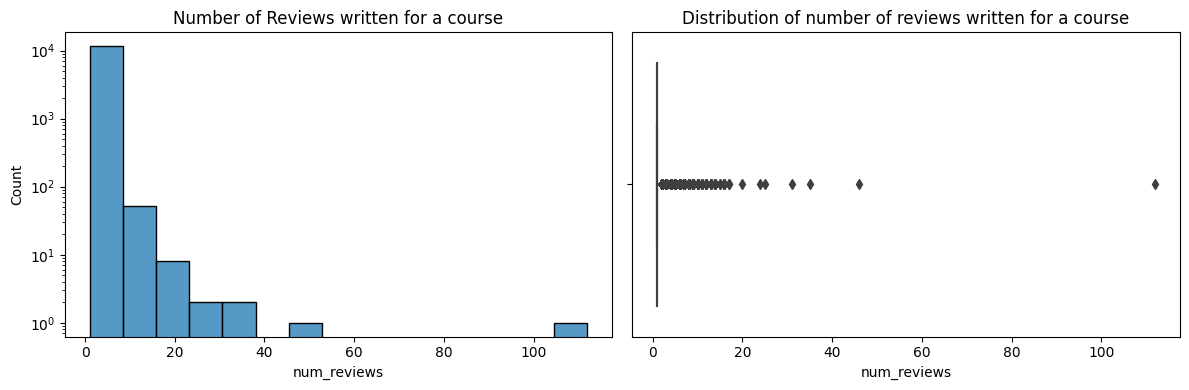

In [194]:
#Histogram distribution for number of reviews written for a course (logarithmic on y axis)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))

g = sns.histplot(data = df, x = 'num_reviews', ax = axes[0])
g.set_yscale('log')
g.set_title("Number of Reviews written for a course")

#Boxplot of distribution of number of reviews written
b = sns.boxplot(data = df, x = 'num_reviews', ax=axes[1]).set_title("Distribution of number of reviews written for a course")

fig.tight_layout()

The histogram is very positively skewed, with the majority of courses (almost 10,000) receiving less than about 5 reviews and the max being one course with over 100 reviews for the semester it was taught.

Average GPA:  3.433031475294573
Average GPA:  3.51


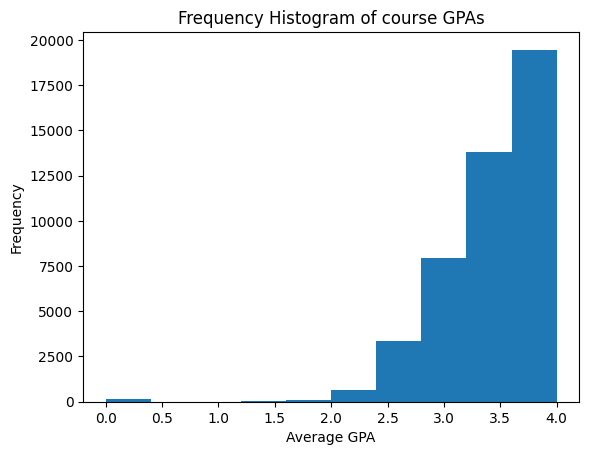

In [195]:
plt.hist(df['average_gpa'])
plt.gca().set(title='Frequency Histogram of course GPAs', ylabel='Frequency', xlabel='Average GPA');
print("Average GPA: ", df['average_gpa'].mean())
print("Average GPA: ", df['average_gpa'].median())

The histogram is very positively skewed, with the majority of courses (almost 10,000) receiving less than about 5 reviews and the max being one course with over 100 reviews for the semester it was taught.

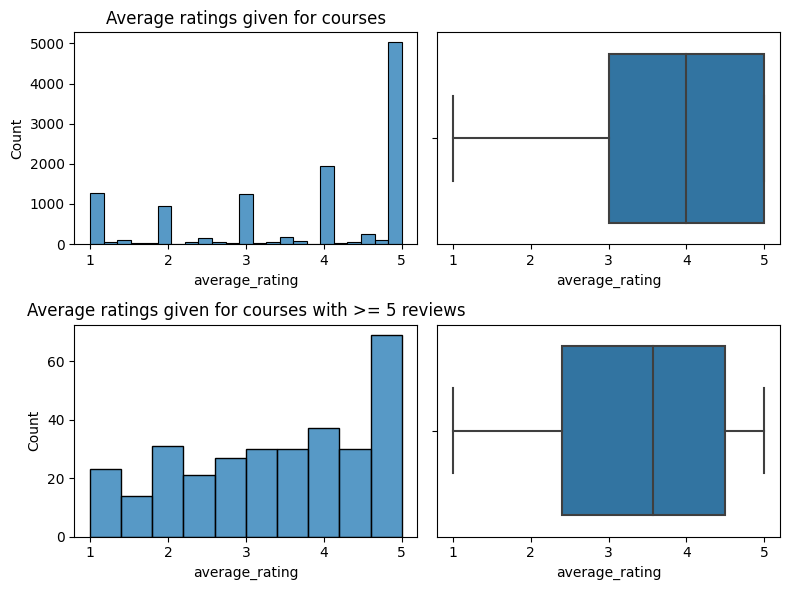

In [196]:
#Average rating plots

#Most students are given classes ratings of close to a 5/5
#Average of average rating is 4, average goes down as courses have more reviews written for it

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))
numReviews = 5

sns.histplot(data = df, x='average_rating', ax = axes[0][0]).set_title("Average ratings given for courses")
sns.boxplot(data = df, x='average_rating', ax = axes[0][1])

sns.histplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][0]).set_title("Average ratings given for courses with >= " + str(numReviews) + " reviews")
sns.boxplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][1])

fig.tight_layout()

Most students are giving courses ratings of close to 5 (close to 5000), with the average rating given being around a 4 out of 5. There are many peaks at the whole number ratings, which makes sense given that PlanetTerp only allows for whole number ratings to be given for a course, and the majority of our data consists of courses with fewer than 5 reviews, making it likely that the average is close to a whole number. In fact, if we only plot rating data for courses with more than 5 reviews, these peaks flatten out.

Next, we made a PairPlot between our variables to get a birds-eye view of the relationships between average rating, average gpa, the number of years a professor has taught, the professor's salary, and the number of students in a course.

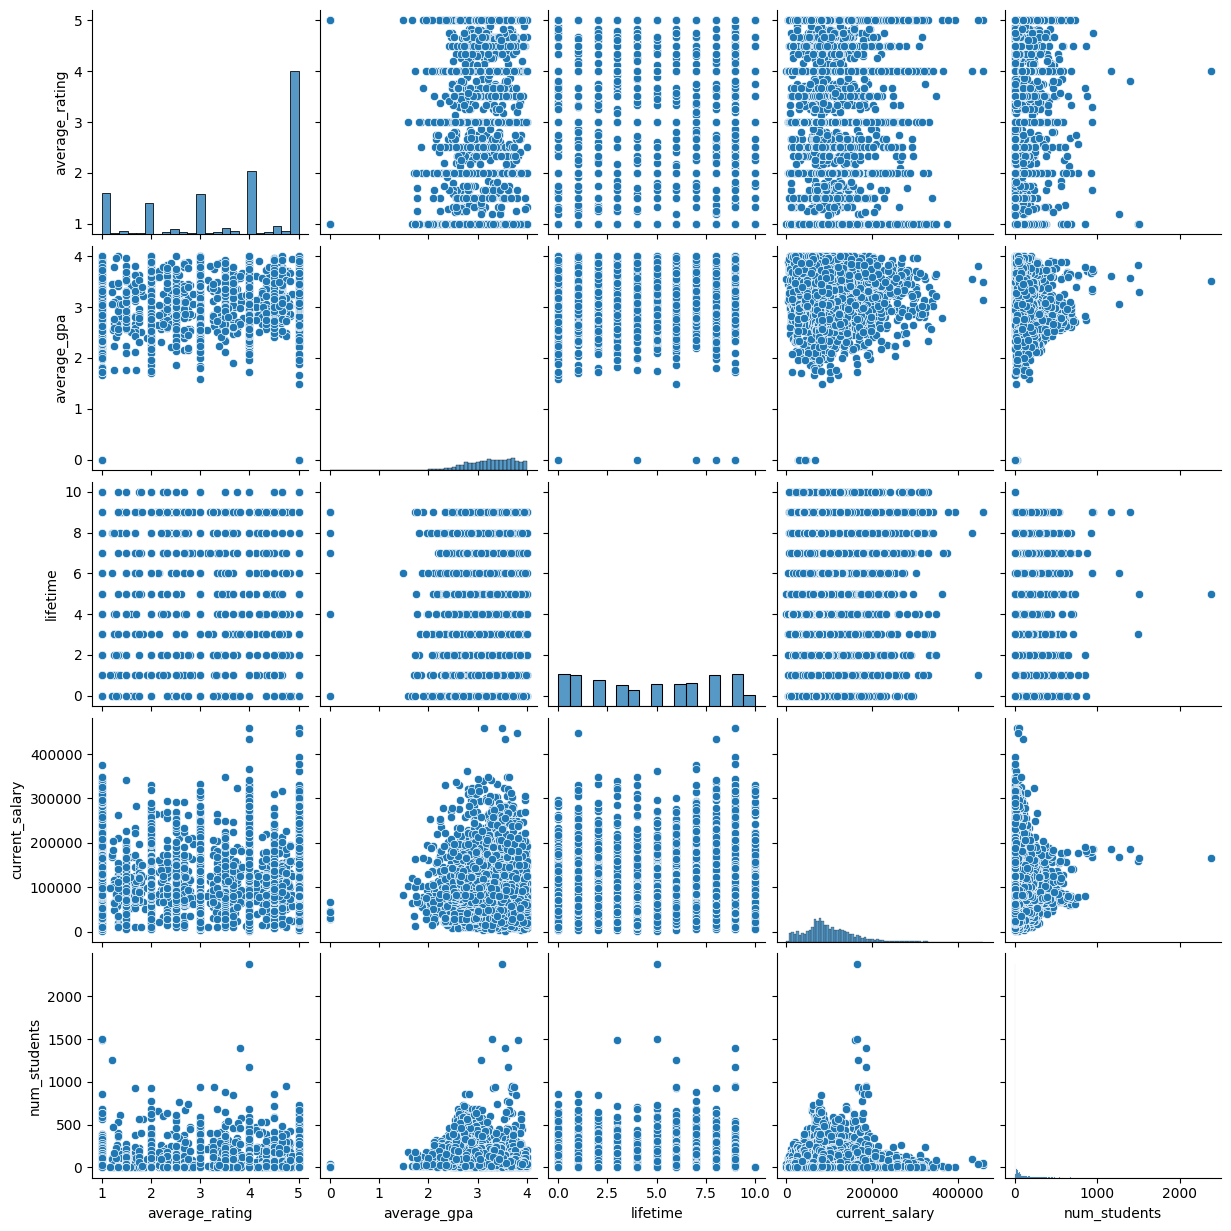

In [197]:
df_test = df[(df['num_reviews'] >= 0)]

g = sns.pairplot(df_test[["average_rating", "average_gpa", "lifetime", "current_salary", "num_students"]])

Each axis contains the five variables we want to find relationships between, and each plot is a scatterplot between two variables given by the x and y axis. Along the diagonal of the PairPlot, a histogram of the counts of each variable is shown.

There is a slight positive correlation between average rating and average_gpa, corroborating the finding from the previous section where we found the same relationship. Another thing we see from the graph above is that there is a positive correlation between lifetime (number of years that a professor has taught) and their salary, as professors who have taught below 3 years never have a salary higher than about $200,000. 

To further explore the correlation between lifetime, salary, and average rating of a professor, we made a scatterplot focusing on just those variables. 

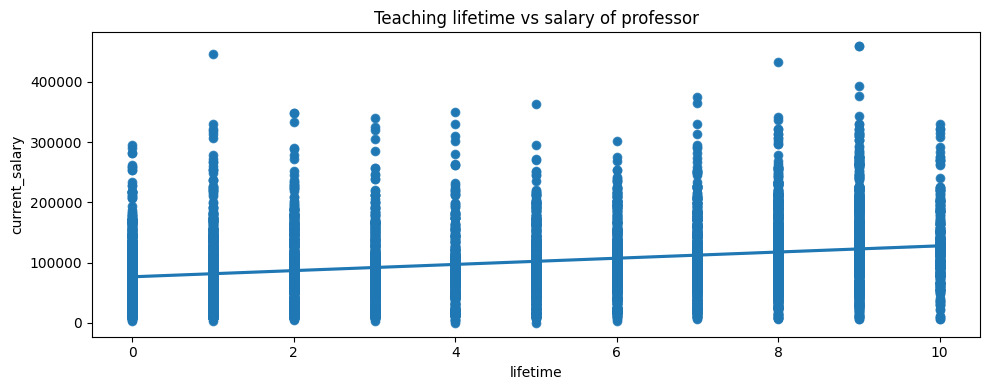

In [198]:
#Relationship between lifetime and salary

fig, axes = plt.subplots(figsize=(10,4))

numReviews = 0

sns.scatterplot(data=df[df['num_reviews'] >= 0], x='lifetime', y='current_salary', ax = axes).set_title("Teaching lifetime vs salary of professor")
sns.regplot(data=df[df['num_reviews'] >= 0], x='lifetime', y='current_salary', ax = axes)
fig.tight_layout()

We see that there is a positive correlation between the number of years a professor has taught and their current salary. This intuitively makes sense from the viewpoint of the administration at UMD, because the university would generally want to reward professors with more experience with a higher salary. Also, there may be automatic salary bumps at the end of each year that leads to this relationship.

To further explore the relationship that a professsor's teaching time at UMD is compared to their performance, we plotted the difference in average rating and GPA across courses taught by professors with different years of teaching experience.

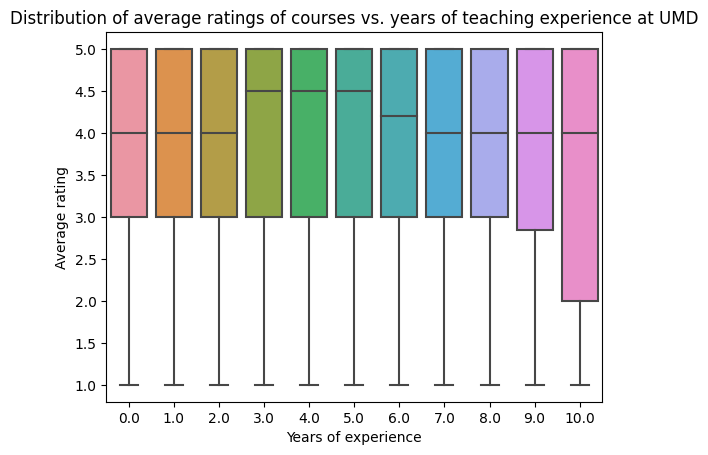

In [199]:
fig, ax = plt.subplots()
rating = {}

for years_taught in sorted(df[df['lifetime'].notna()]['lifetime'].unique()):
    df_years_taught = df[(df['lifetime'] == years_taught) & (df['num_students'].notna())]
    rating[years_taught] = df_years_taught['average_rating']    

df_ratings = pd.DataFrame.from_dict(rating)
s = sns.boxplot(data=df_ratings)
s.set(title="Distribution of average ratings of courses vs. years of teaching experience at UMD", xlabel='Years of experience', ylabel='Average rating')
#sns.lineplot(x=np.arange(0,10), y=median_gpas, c='red', linewidth=3)

plt.show()

There isn't a general upward trend in the means of the average rating as a professor gets more experienced - as it hovers around a 4 to a 4.5 across all years - but we do see that past 7 years of experience, the interquartile range gets wider, meaning teachers with high experience are getting many lower than average ratings. 

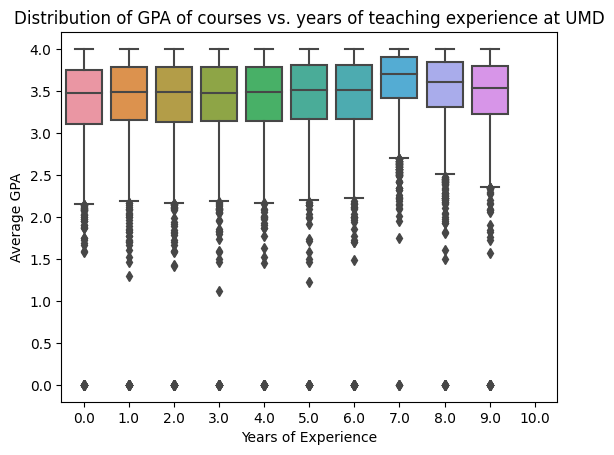

In [200]:
#GPA of courses taught by professors with different years of teaching experience
fig, ax = plt.subplots()
gpa = {}
median_gpas = []

for years_taught in sorted(df[df['lifetime'].notna()]['lifetime'].unique()):
    df_years_taught = df[(df['lifetime'] == years_taught) & (df['average_gpa'].notna())]
    gpa[years_taught] = df_years_taught['average_gpa']
    median_gpas.append(df_years_taught['average_gpa'].median())
    

df_gpa = pd.DataFrame.from_dict(gpa)
s = sns.boxplot(data=df_gpa)
s.set(title="Distribution of GPA of courses vs. years of teaching experience at UMD", xlabel='Years of Experience', ylabel='Average GPA')

plt.show()

However, there does not appear to be a correlation between the average GPA of a course and the years of experience the professor teaching that course has. Except for a professor with 7 years of experience, the average GPA is slightly below 3.4 across the experience levels, aligning with our overall average GPA at UMD of 3.43.

There may be a difference in the average GPA and average rating given the department the course was a part of. We explored this below.

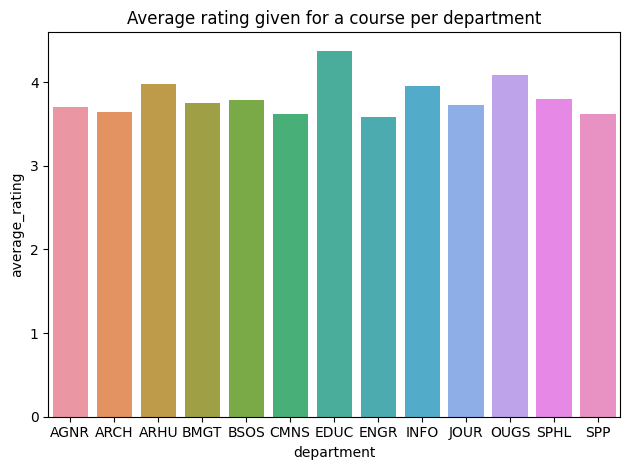

In [201]:
#Average rating given in each department

s = sns.barplot(data = df.groupby('department')['average_rating'].mean().reset_index(), x = 'department', y='average_rating')
s.set(title="Average rating given for a course per department")
plt.tight_layout()

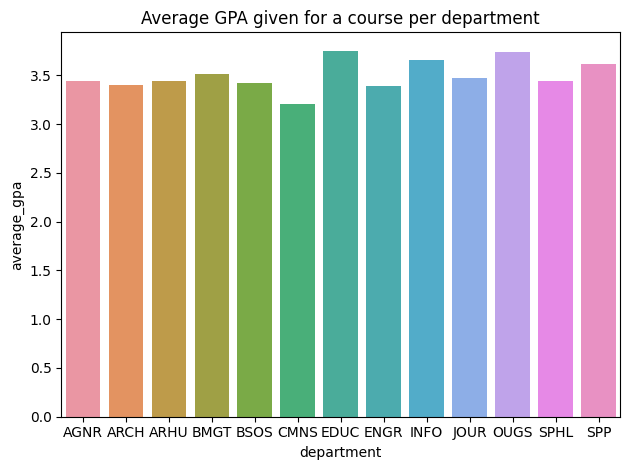

In [202]:
#Average rating given in each department

s = sns.barplot(data = df.groupby('department')['average_gpa'].mean().reset_index(), x = 'department', y='average_gpa')
s.set(title="Average GPA given for a course per department")
plt.tight_layout()

Courses taught in the College of Education (EDUC) and Office of Undergraduate Studies (OUGS) appear to have both the highest average ratings and average GPAs among the departments. These departments having both the highest average rating and GPA further reinforces a trend that we are seeing among our data; that if professor's ratings are higher, their average course GPA tends to be higher as well. 

# Analysis, Hypothesis Testing, and ML <a class="anchor" id = "analysis-hypothesis-testing-ml"></a>

[Back to Top](#table)

The next step in the data science pipeline is data analysis, hpothesis testing, and machine learning. There's no reason to examine the data if we aren't to perform some tests on it. Intution alone isn't enough to conclude any proper results that can be supported in a policy action or change. Thus, we must use algorithms to determine any relationships between variables, and if it is strong enough to actually change anything.

### Independent Variables vs Dependent Variables <a class="anchor" id = "aaron-time"></a>


After looking at the data that we plotted, we want to look at the relationships between each independent variable to each dependent variable. Since there are two independent variables and two dependent variables, there are 4 regressions we are making.

We need to create variables that pair the variables together in new dataframes so that we can drop the NaN values for each column without affecting the other regressions we are making. For example, a row may be missing a rating, but if we are doing an analysis on the time a teacher has been teaching vs the average gpa of that class, we don't want to remove that row.


In [203]:
# Getting and splitting dataset into training and testing data

lifeTimeGrades = df[['lifetime', 'average_gpa']]
lifeTimeGrades.dropna(inplace=True)
lifeTimeRating = df[['lifetime', 'average_rating']]
lifeTimeRating.dropna(inplace=True)
salaryGrades = df[['current_salary', 'average_gpa']]
salaryGrades.dropna(inplace=True)
salaryRating = df[['current_salary', 'average_rating']]
salaryRating.dropna(inplace=True)
lsGrades = df[['lifetime', 'current_salary', 'average_gpa']]
lsGrades.dropna(inplace=True)
lsRating = df[['lifetime', 'current_salary', 'average_rating']]
lsRating.dropna(inplace=True)

Next, we perform the linear regression on the data. Based on the data given in data visualization, we don't expect to see too much of a relationship linearly.

0.007793159218596135


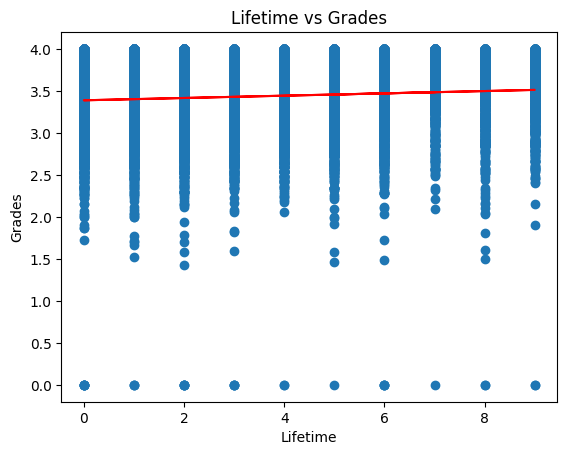

-0.0002646354774540338


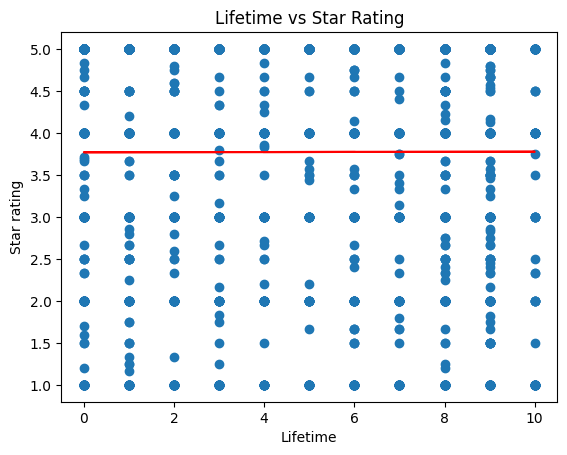

0.0006477196794330009


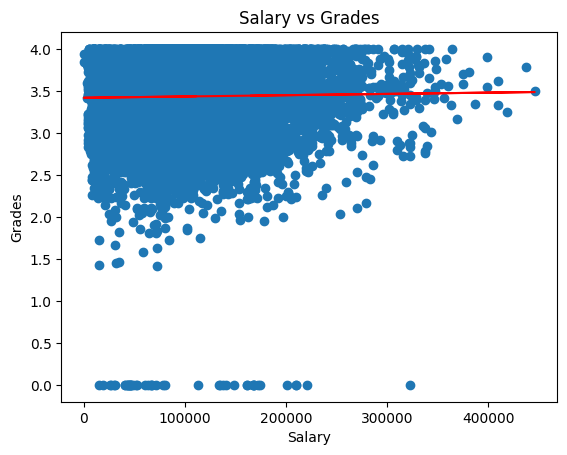

0.0034571856739065154


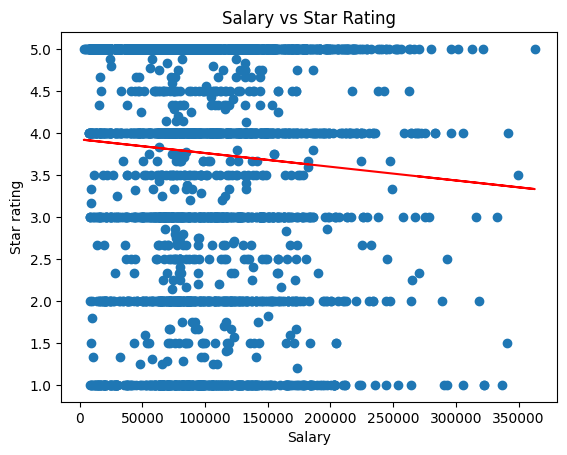

0.004349964113033233


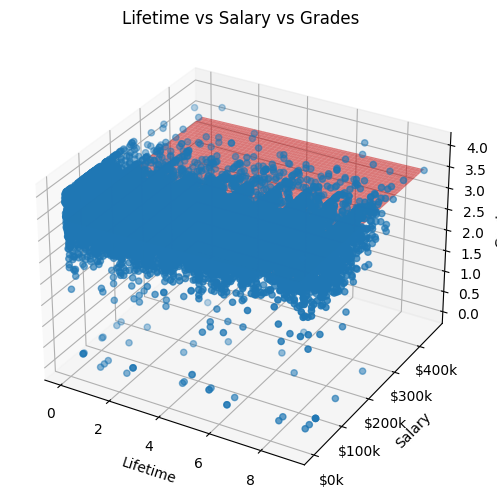

0.006626511678791802


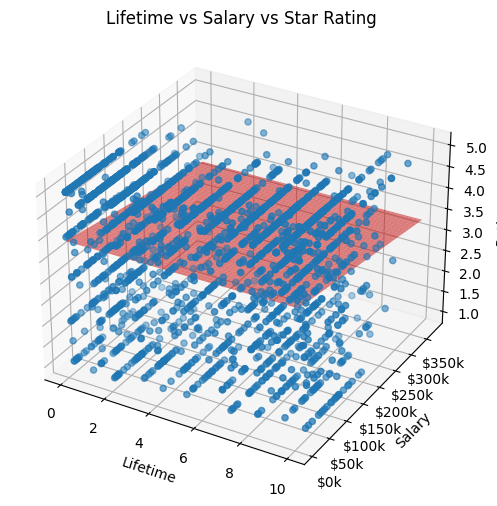

In [204]:
import sklearn.model_selection
import sklearn.linear_model
# Linear Regression Analysis

# Regression of lifetime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.title('Lifetime vs Grades')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.title('Lifetime vs Star Rating')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), grade_train)
print(linear.score(np.array(salary_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.title('Salary vs Grades')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()
# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), rating_train)
print(linear.score(np.array(salary_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.title('Salary vs Star Rating')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), grade_train)
print(linear.score(ls_test, grade_test))
gradePredict = linear.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], grade_test)
ax.set_title('Lifetime vs Salary vs Grades')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Grades')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the linear regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = linear.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), rating_train)
print(linear.score(ls_test, rating_test))
ratingPredict = linear.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], rating_test)
ax.set_title('Lifetime vs Salary vs Star Rating')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Rating')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the linear regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = linear.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

As we can see, the regression is having a hard time modeling to the data, since it is seemingly sporatic and has no relationship. We can see it with the score($R^2$) being very low and not close to one. But even with the bad score, we can learn a few things from these graphs, that there is somewhat a positive relationship between grades and lifetime, and grades and score. 

Since the linear relationship wasn't great, let's do an analysis on the logistic regression of the data points. We will use the same data points and structure ans the linear regression

0.7577045696068013


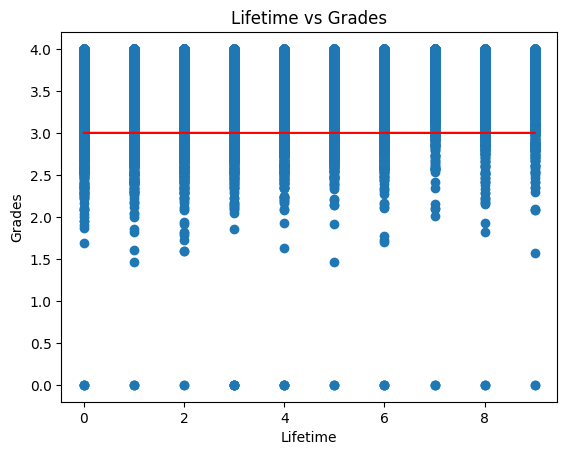

0.46554552912223135


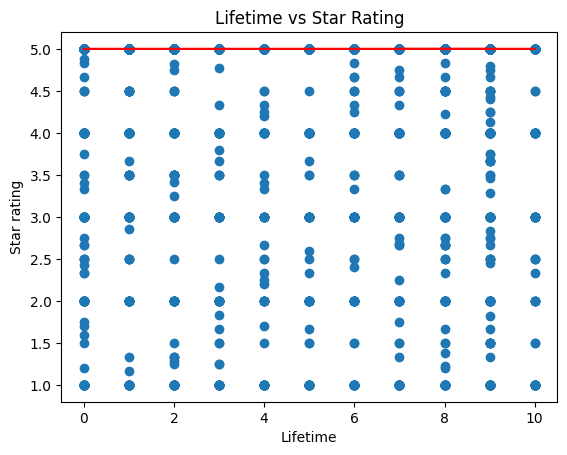

0.7551468972085867


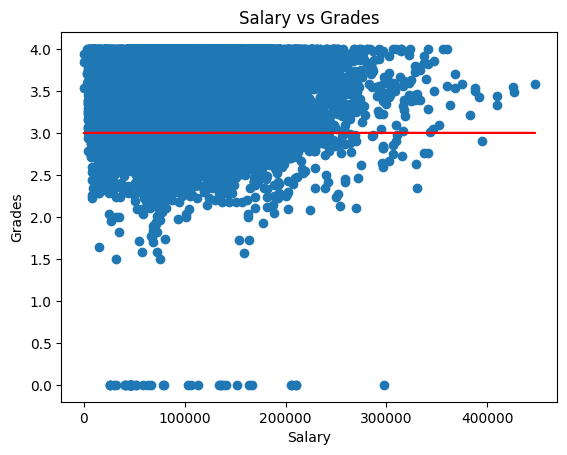

0.43117697349672274


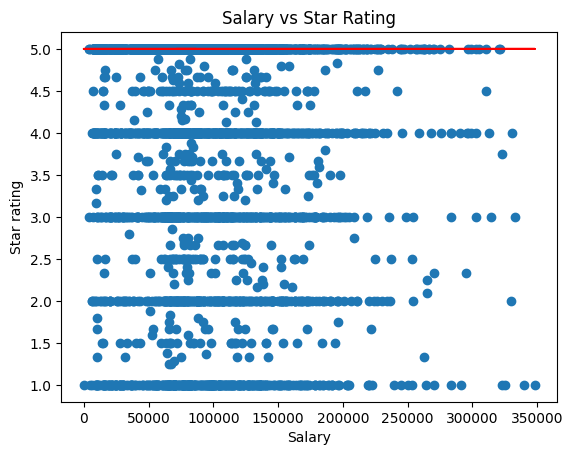

0.7592577454426551


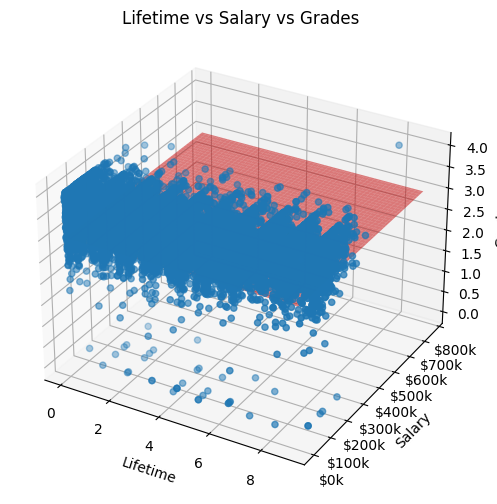

0.46267432321575064


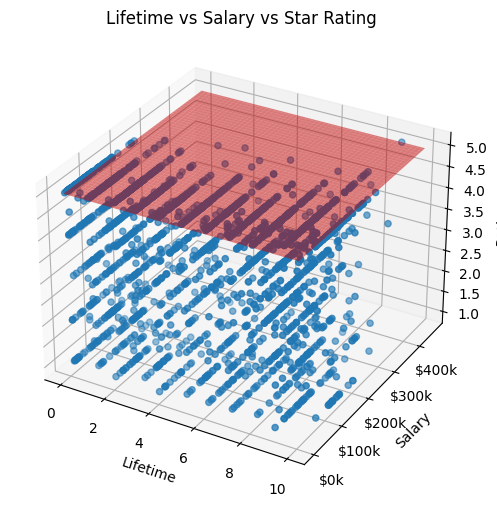

In [205]:
#Regression of liftime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.title('Lifetime vs Grades')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.title('Lifetime vs Star Rating')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.title('Salary vs Grades')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()

# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.title('Salary vs Star Rating')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), grade_train.astype('int'))
print(logistic.score(ls_test, grade_test.astype('int')))
gradePredict = logistic.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], grade_test)
ax.set_title('Lifetime vs Salary vs Grades')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Grades')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the logistic regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = logistic.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), rating_train.astype('int'))
print(logistic.score(ls_test, rating_test.astype('int')))
ratingPredict = logistic.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], rating_test)
ax.set_title('Lifetime vs Salary vs Star Rating')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Rating')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the logistic regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = logistic.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

These scores are a lot higher. We can be more inclined to accept these models. Again, we see a closer relationship between grades and lifetime and grades and salary. Now, the regression line that appears linear, but upon further investigation, we see that the reason for this is due to the fact that the plot is only capturing a small portion of either the head or the tail of the regression line, which is making it look seemingly linear. But again, because it is only displaying this small portion of the graph, we are more inclined to reject this model as well. 

Next, we want to examine if we can produce a support vector machine out of this. Again, since we found no linear or logistic relationship between the variables, we are predicting that the SVM will not be accurate either. First, since an SVM takes two independent variables and categorizes them as a dependent variable/output, we want to categorize our numerical grades (0-4), into a letter grade(A-F). We then separate them into variable pairs to prevent dropping unecessary rows as explained earlier.

In [206]:
def addCategorizedGrade(data):
    data['categorized_grade'] = ""
    for index, row in data.iterrows():
        if row['average_gpa'] > 3.7:
            data.loc[index, 'categorized_grade'] = "A"
        elif row['average_gpa'] > 3.3:
            data.loc[index, 'categorized_grade'] = "A-"
        elif row['average_gpa'] > 3.0:
            data.loc[index, 'categorized_grade'] = "B+"
        elif row['average_gpa'] > 2.7:
            data.loc[index, 'categorized_grade'] = "B"
        elif row['average_gpa'] > 2.3:
            data.loc[index, 'categorized_grade'] = "B-"
        elif row['average_gpa'] > 2.0:
            data.loc[index, 'categorized_grade'] = "C+"
        elif row['average_gpa'] > 1.7:
            data.loc[index, 'categorized_grade'] = "C"
        elif row['average_gpa'] > 1.3:
            data.loc[index, 'categorized_grade'] = "C-"
        elif row['average_gpa'] > 1.0:
            data.loc[index, 'categorized_grade'] = "D+"
        elif row['average_gpa'] > 0.7:
            data.loc[index, 'categorized_grade'] = "D"
        else:
            data.loc[index, 'categorized_grade'] = "F"

In [207]:
# Creating categorized values for SVM

df_svm = df.copy()
df_svm = df_svm[df_svm['average_gpa'].notna() & df_svm['lifetime'].notna()]

# Categorize grades
teacherLifetimeGrades = df[(df['lifetime'].notna()) & (df['average_gpa'].notna())]
teacherLifetimeRating = df[(df['lifetime'].notna()) & (df['average_rating'].notna())]
salaryGrades = df[(df['current_salary'].notna()) & (df['average_gpa'].notna())]
salaryRating = df[(df['current_salary'].notna()) & (df['average_rating'].notna())]
lsGrades = df[(df['lifetime'].notna()) & (df['current_salary'].notna()) & (df['average_gpa'].notna())]
lsRating = df[(df['lifetime'].notna()) & (df['current_salary'].notna()) & (df['average_rating'].notna())]

addCategorizedGrade(teacherLifetimeGrades)
addCategorizedGrade(salaryGrades)
addCategorizedGrade(lsGrades)

teacherLifetimeGrades = teacherLifetimeGrades[['lifetime', 'categorized_grade']]
teacherLifetimeRating = teacherLifetimeRating[['lifetime', 'average_rating']]
salaryGrades = salaryGrades[['current_salary', 'categorized_grade']]
salaryRating = salaryRating[['current_salary', 'average_rating']]
lsGrades = lsGrades[['lifetime', 'current_salary', 'categorized_grade']]
lsRating = lsRating[['lifetime', 'current_salary', 'average_rating']]

#categorize rating data
teacherLifetimeRating['average_rating'] = teacherLifetimeRating['average_rating'].astype(int) 
salaryRating['average_rating'] = salaryRating['average_rating'].astype(int) 
lsRating['average_rating'] = lsRating['average_rating'].astype(int) 

Now that we prepared our variables, we can perform the SVM

In [208]:
def performanceMetrics(groundTruth, predictions):
    accuracy = accuracy_score(groundTruth, predictions)
    return accuracy

In [209]:
# SVM Analysis

# SVM of lifetime and salary vs grades
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lsGrades[['lifetime', 'current_salary']], lsGrades['categorized_grade'], test_size=0.3)
svm = sklearn.svm.SVC().fit(np.array(ls_train), grade_train)
svm.score(np.array(ls_test), grade_test)
gradePredict = svm.predict(np.array(ls_test))

print("Accuracy of SVM of lifetime and salary and grades:", performanceMetrics(grade_test, gradePredict))

# SVM of lifetime and salary vs rating
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lsRating[['lifetime', 'current_salary']], lsRating['average_rating'], test_size=0.3)
svm = sklearn.svm.SVC().fit(np.array(ls_train), rating_train)
svm.score(np.array(ls_test), rating_test)
ratingPredict = svm.predict(np.array(ls_test))

print("Accuracy of SVM of lifetime and salary and grades:", performanceMetrics(rating_test, ratingPredict))

Accuracy of SVM of lifetime and salary and grades: 0.35641298128014387
Accuracy of SVM of lifetime and salary and grades: 0.43232157506152585


Lastly, we want to perform a K Nearest Neighbors Algorithm on the data to see if we can predict the dependent variables, namely average grade of the class and ratings.

### Grades vs Reviews <a class="anchor" id = "grades-vs-reviews"></a>

Now that we've analyzed how grades and reviews impact a teacher's salary, we can examine how grades and reviews affect one another. Are they inherently linked, either by easier teachers receiving higher reviews or by better teachers being more effective in their teaching and thus having higher grade distributions? This is what we will now try to analyze.

In [210]:
# merge on professor and course, no longer worried about semester

avg_reviews_df = pd.DataFrame()
classes = {}
count = 0
curr_prof = reviews_df.at[0, "name"]
curr_slug = reviews_df.at[0, "slug"]
# iterate through the reviews
for index, row in reviews_df.iterrows():
    if reviews_df.at[index, "name"] == curr_prof:
        if reviews_df.at[index, "course"] in classes:
            # add to the average
            classes[reviews_df.at[index, "course"]] = [classes.get(reviews_df.at[index, "course"])[0] + reviews_df.at[index, "rating"], 
                                                       classes.get(reviews_df.at[index, "course"])[1] + 1]
        else:
            classes[reviews_df.at[index, "course"]] = [reviews_df.at[index, "rating"],1]
    else:
        # add to the dataframe
        for i in classes.keys():
            avg_reviews_df.at[count, "name"] = curr_prof
            avg_reviews_df.at[count, "course"] = i
            avg_reviews_df.at[count, "slug"] = curr_slug
            avg_reviews_df.at[count, "average_rating"] = classes.get(i)[0]/classes.get(i)[1]
            avg_reviews_df.at[count, "num_ratings"] = classes.get(i)[1]
            count = count + 1
        classes = {}
        curr_prof = reviews_df.at[index, "name"]
        curr_slug = reviews_df.at[index, "slug"]

avg_reviews_df.head()

,name,course,slug,average_rating,num_ratings
0,A Anthony,AMST203,anthony,1.000000,1.0
1,A Sharma,ASTR300,sharma_a,2.000000,4.0
2,A.U. Shankar,CMSC216,shankar_a.u.,2.222222,18.0
3,A.U. Shankar,CMSC412,shankar_a.u.,3.200000,5.0
4,Aaron Bartlett,ENGL265,bartlett,2.000000,3.0


In [211]:
# merge on professor and course, no longer worried about semester

avg_grades_df = pd.DataFrame()
classes = {}
gpa = {"A+":4.0, "A":4.0, "A-":3.7,"B+":3.3, "B":3.0, "B-":2.7, "C+":2.3, "C":2.0, "C-":1.7, "D+":1.3, "D":1.0, "D-":0.7, "F":0.0}
count = 0
curr_prof = grades_df.at[0, "professor"]
# iterate through the grades
for index, row in grades_df.iterrows():
    curr_gpa = [0, 0]
    for i in gpa.keys():
        # add to the average
        curr_gpa[0] = curr_gpa[0] + gpa.get(i)*grades_df.at[index, i]
        curr_gpa[1] = curr_gpa[1] + grades_df.at[index, i]
    if grades_df.at[index, "professor"] == curr_prof:
        if grades_df.at[index, "course"] in classes:
            classes[grades_df.at[index, "course"]] = [classes.get(grades_df.at[index, "course"])[0] + curr_gpa[0], 
                                                      classes.get(grades_df.at[index, "course"])[1] + curr_gpa[1]]
        else:
            classes[grades_df.at[index, "course"]] = curr_gpa
    else:
        for i in classes.keys():
            # add to the dataframe
            if classes.get(i)[1] != 0:
                avg_grades_df.at[count, "name"] = curr_prof
                avg_grades_df.at[count, "course"] = i
                avg_grades_df.at[count, "average_gpa"] = (classes.get(i)[0])/(classes.get(i)[1])
                avg_grades_df.at[count, "num_students"] = classes.get(i)[1]
                count = count + 1
        classes = {}
        curr_prof = grades_df.at[index, "professor"]

avg_grades_df.head()

,name,course,average_gpa,num_students
0,A Anthony,AMST202,2.693617,47.0
1,A Anthony,AMST203,2.914130,92.0
2,A Kruglanski,PSYC489H,3.550000,8.0
3,A Kruglanski,PSYC489T,3.561702,94.0
4,A Kruglanski,PSYC604,3.544828,29.0


In [212]:
both_avg_df = pd.DataFrame()

# inner join on name and course
both_avg_df = pd.merge(
    avg_reviews_df,
    avg_grades_df,
    how = "inner",
    on = ["name", "course"]
)

both_avg_df.head()

,name,course,slug,average_rating,num_ratings,average_gpa,num_students
0,A Anthony,AMST203,anthony,1.000000,1.0,2.914130,92.0
1,A Sharma,ASTR300,sharma_a,2.000000,4.0,2.964706,221.0
2,A.U. Shankar,CMSC216,shankar_a.u.,2.222222,18.0,2.357948,692.0
3,A.U. Shankar,CMSC412,shankar_a.u.,3.200000,5.0,2.809319,279.0
4,Aaron Bartlett,ENGL265,bartlett,2.000000,3.0,3.296552,29.0


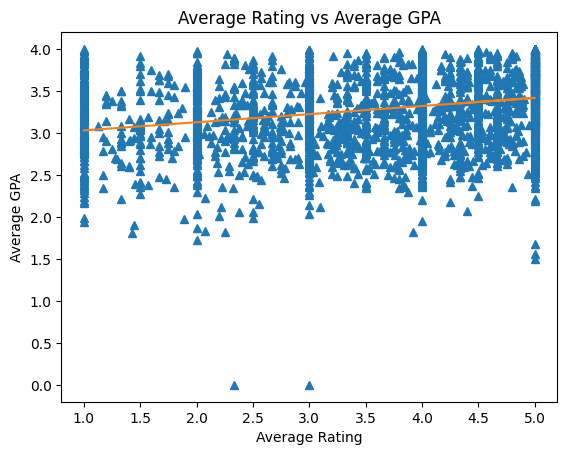

In [213]:
x = both_avg_df["average_rating"]
y = both_avg_df["average_gpa"]
reg = linear_model.LinearRegression()

# Regression of average rating vs average gpa
x_train = [[x] for x in both_avg_df["average_rating"].values]
y_train = [[y] for y in both_avg_df["average_gpa"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.close()
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Rating vs Average GPA")
plt.ylabel("Average GPA")
plt.xlabel("Average Rating")
plt.show()

It looks like a majority of the data points are all at either a rating of one of the whole numbers. This is likely due to a lot of professors only having very little reviews for a specific class, leading the sample size to be extremely small. In this case, we can then make our data only include classes for which a professor has five or more reviews.

In [214]:
# getting rid of professor/class combinations with less than 5 reviews

five_or_more_df = pd.DataFrame()
count = 0

for index, row in both_avg_df.iterrows():
    if both_avg_df.at[index, "num_ratings"] >= 5:
        five_or_more_df.at[count, "name"] = both_avg_df.at[index, "name"]
        five_or_more_df.at[count, "slug"] = both_avg_df.at[index, "slug"]
        five_or_more_df.at[count, "course"] = both_avg_df.at[index, "course"]
        five_or_more_df.at[count, "average_rating"] = both_avg_df.at[index, "average_rating"]
        five_or_more_df.at[count, "num_ratings"] = both_avg_df.at[index, "num_ratings"]
        five_or_more_df.at[count, "average_gpa"] = both_avg_df.at[index, "average_gpa"]
        five_or_more_df.at[count, "num_students"] = both_avg_df.at[index, "num_students"]
        count = count + 1

five_or_more_df.head()

,name,slug,course,average_rating,num_ratings,average_gpa,num_students
0,A.U. Shankar,shankar_a.u.,CMSC216,2.222222,18.0,2.357948,692.0
1,A.U. Shankar,shankar_a.u.,CMSC412,3.200000,5.0,2.809319,279.0
2,Aaron Finkle,finkle,ECON306,2.500000,8.0,2.706983,2678.0
3,Aaron Swanlek,swanlek,COMM107,5.000000,7.0,3.938579,394.0
4,Abigail Nicolas,nicolas_abigail,PSYC221,5.000000,8.0,3.557846,325.0


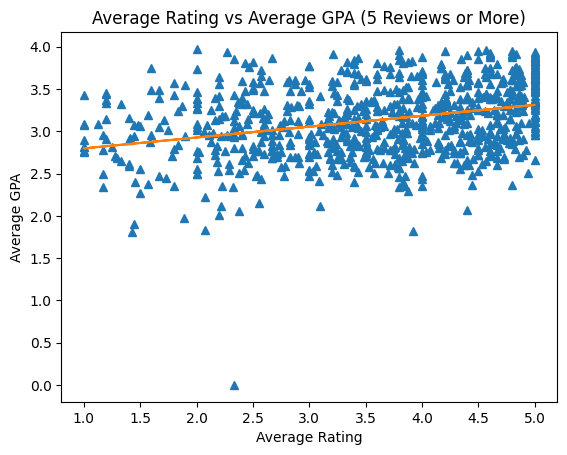

In [215]:
x = five_or_more_df["average_rating"]
y = five_or_more_df["average_gpa"]

# Regression of average rating vs average gpa
reg = linear_model.LinearRegression()
x_train = [[x] for x in five_or_more_df["average_rating"].values]
y_train = [[y] for y in five_or_more_df["average_gpa"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Rating vs Average GPA (5 Reviews or More)")
plt.ylabel("Average GPA")
plt.xlabel("Average Rating")
plt.show()

Now there is less concentration of our data at these values. There appears to be a general positive trend and slight relationship between the average rating of a professor class combination and the average GPA for that same combination. However, in order to gain more insight into whether or not this is a consistent trend, it would be nice to hold some things constant. We would like to see if this trend continues for a single professor teaching different classes or for different professors teaching the same class.

There are 14 professors teaching 4 or more classes that have 5 or more reviews at UMD. In order to avoid small sample sizes, we will analyze these 14 professors, and see if there is any relationship between reviews and GPA for the classes that they teach.

In [216]:
multi_prof = {}
curr_prof = None
classes = [[]]
multi = False
for index, row in five_or_more_df.iterrows():
    # gets all of the professors that teach multiple classes
    classes.append([five_or_more_df.at[index, "course"],
                    five_or_more_df.at[index, "average_rating"],
                    five_or_more_df.at[index, "num_ratings"],
                    five_or_more_df.at[index, "average_gpa"],
                    five_or_more_df.at[index, "num_students"]])
    if five_or_more_df.at[index, "name"] == curr_prof:
        multi = True
    else:
        if multi == True:
            multi_prof[curr_prof] = classes
            multi = False
        classes = []
        curr_prof = five_or_more_df.at[index, "name"]

# puts all of these professors in a dataframe, sorting them by number of classes they teach
multi_prof_df = pd.DataFrame()

count = 0
for i in multi_prof.keys():
    multi_prof_df.at[count, "name"] = i
    multi_prof_df.at[count, "num_classes"] = len(multi_prof.get(i))
    count = count + 1

multi_prof_df = multi_prof_df.sort_values(by = "num_classes", ascending = False, ignore_index = True)

# copy over the information for the 14 professors with the most classes
most_classes_profs = []

for i in range(14):
    most_classes_profs.append(multi_prof_df.at[i, "name"])

most_classes_profs_df = pd.DataFrame()
count = 0

for index, row in five_or_more_df.iterrows():
    if five_or_more_df.at[index, "name"] in most_classes_profs:
        most_classes_profs_df.at[count, "name"] = five_or_more_df.at[index, "name"]
        most_classes_profs_df.at[count, "course"] = five_or_more_df.at[index, "course"]
        most_classes_profs_df.at[count, "average_rating"] = five_or_more_df.at[index, "average_rating"]
        most_classes_profs_df.at[count, "num_ratings"] = five_or_more_df.at[index, "num_ratings"]
        most_classes_profs_df.at[count, "average_gpa"] = five_or_more_df.at[index, "average_gpa"]
        most_classes_profs_df.at[count, "num_students"] = five_or_more_df.at[index, "num_students"]
        count = count + 1

most_classes_profs_df.head()

,name,course,average_rating,num_ratings,average_gpa,num_students
0,Bonnie Dixon,BCHM463,2.666667,12.0,2.769094,1291.0
1,Bonnie Dixon,CHEM131,3.842105,19.0,2.707407,243.0
2,Bonnie Dixon,CHEM134,2.166667,6.0,2.723111,225.0
3,Bonnie Dixon,CHEM135,3.758621,29.0,2.612654,893.0
4,Bonnie Dixon,CHEM231,4.205882,68.0,2.730612,2829.0


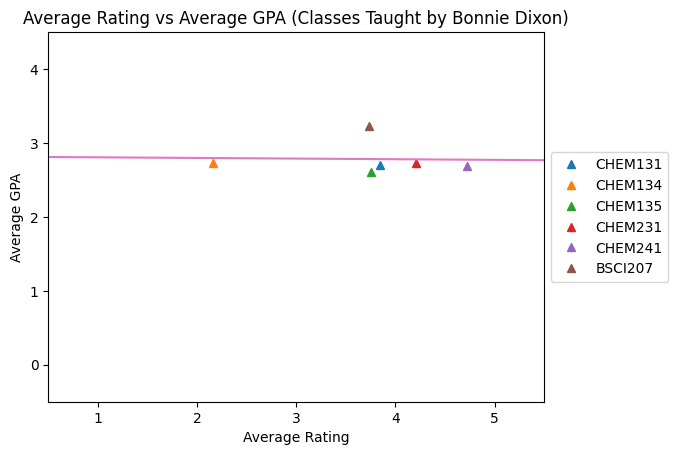

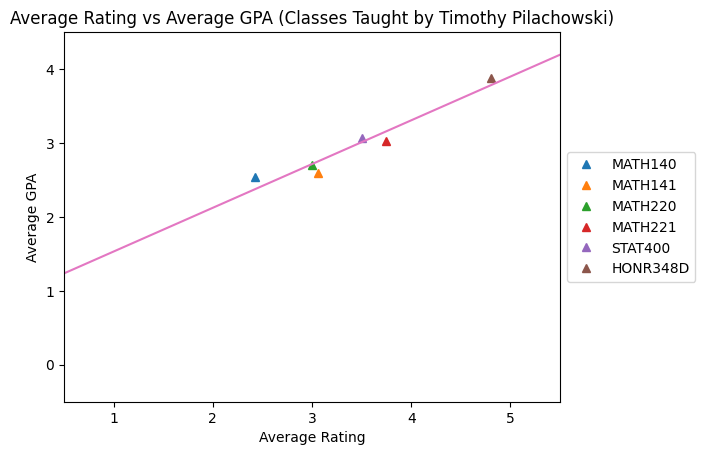

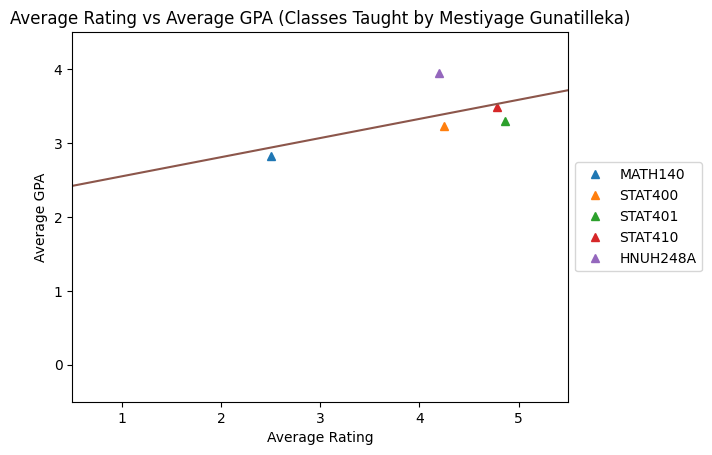

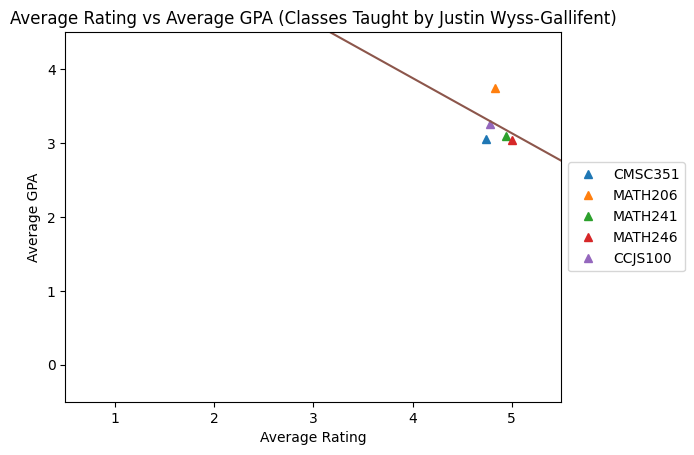

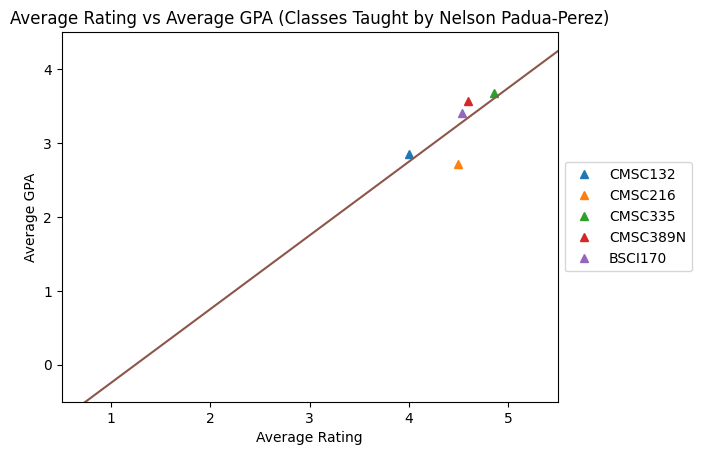

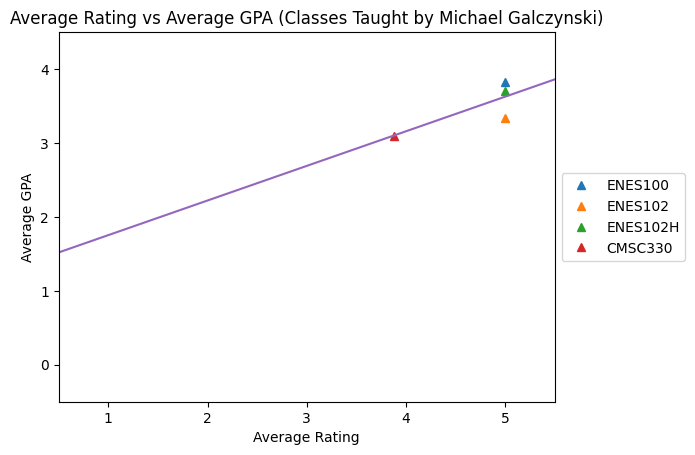

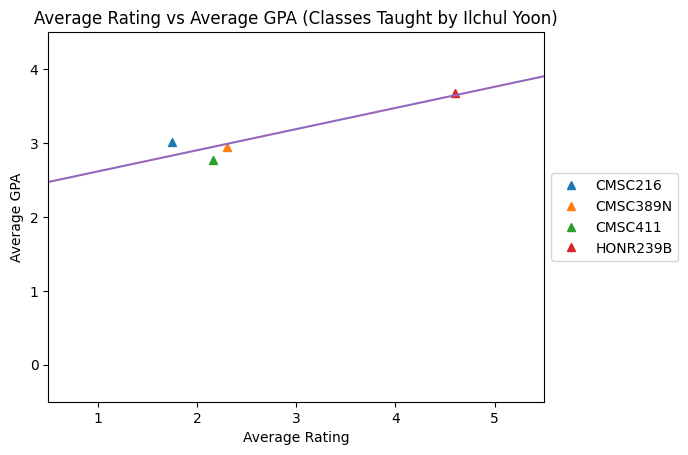

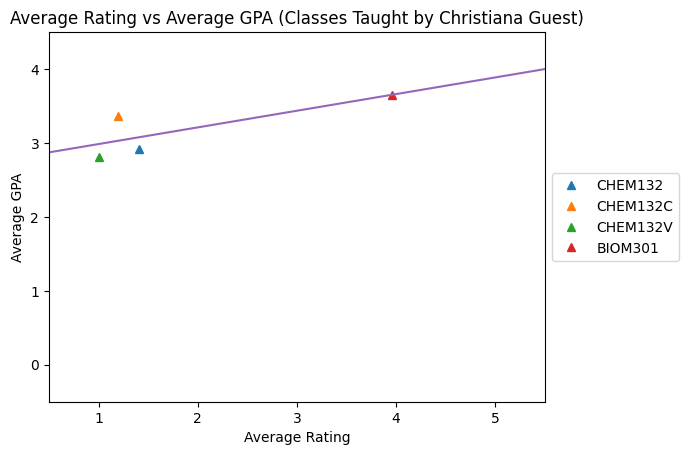

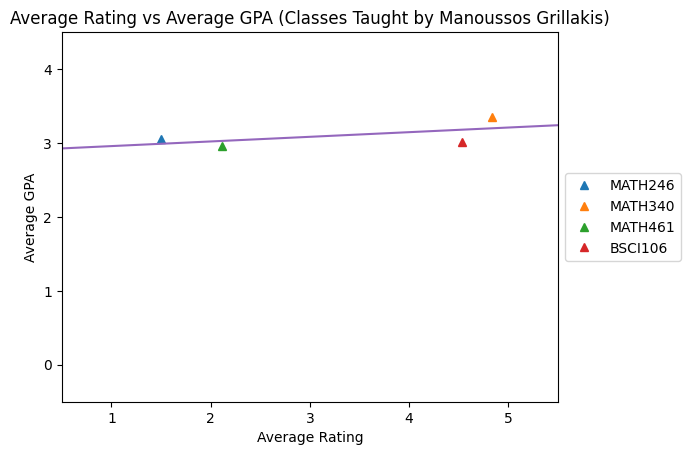

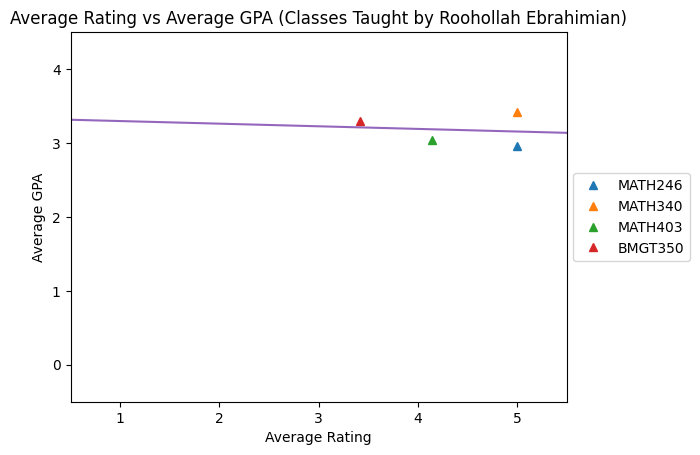

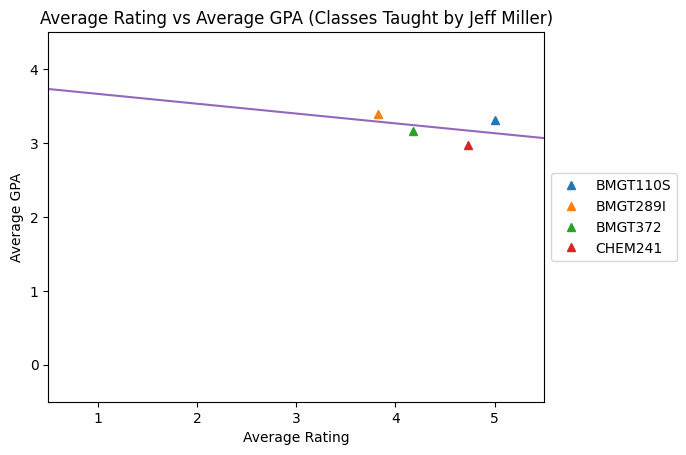

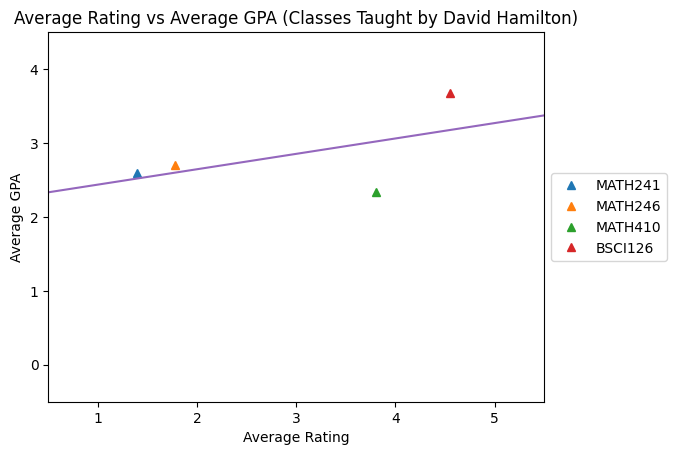

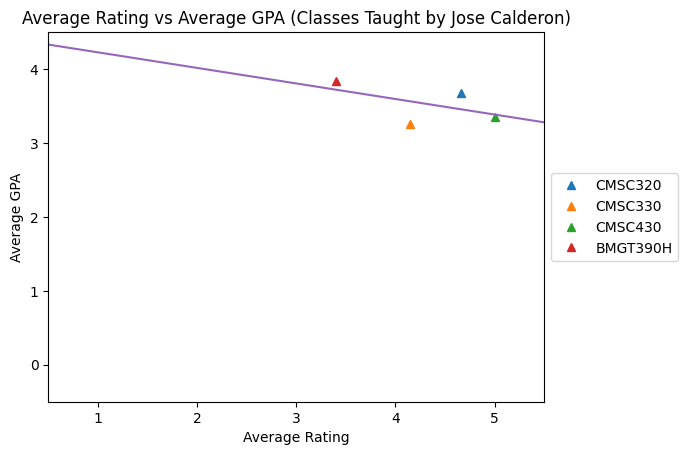

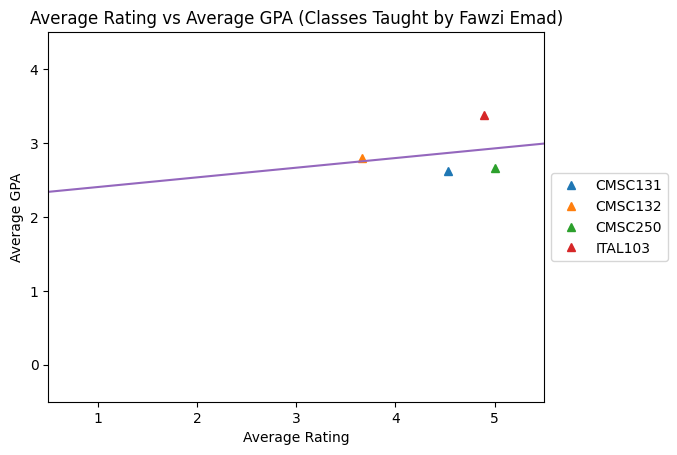

In [217]:
for i in most_classes_profs:
    courses = []
    ratings = []
    gpas = []

    # store all of the course information for each professor
    for j in multi_prof.get(i):
        courses.append(j[0])
        ratings.append(j[1])
        gpas.append(j[3])

    for j in range(len(courses)):
        plt.plot(ratings[j], gpas[j], "^", label = courses[j])

    plt.title("Average Rating vs Average GPA (Classes Taught by " + i + ")")
    plt.ylabel("Average GPA")
    plt.xlabel("Average Rating")
    plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
    # linear regression for each professor
    ratings = np.array(ratings).reshape(-1, 1)
    reg = linear_model.LinearRegression()
    regfit = reg.fit(ratings, gpas)
    X = np.linspace(-100, 100)
    y_pred = reg.predict(np.array(X).reshape(-1,1))
    plt.plot(X,y_pred)
    plt.xlim(0.5, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.show()

It appears that, in general, there is either little to no correlation between average rating and average GPA for differnet classes taught by the same professor. This is most prominent in professors that have a large range of ratings, such as Timothy Pilachowski and Ichul Yoon. The few exceptions, namely Justin Wyss-Gallifent and Jose Calderon both have very high ratings in general, limiting the spread of their ratings and thus the information that the calculated regression has to go on.

Now, we would like to perform the same task, except see if different professors teaching the same class will result in different average ratings and GPAs. There are 10 classes that have been taught by 9 or more professors, each with 5 or more reviews on PlanetTerp.

In [218]:
multi_course = {}
curr_course = None
profs = [[]]
multi = False

# get all of the classes that have been taught by multiple professors
five_or_more_df = five_or_more_df.sort_values(by = "course", ignore_index = True)

for index, row in five_or_more_df.iterrows():
    profs.append([five_or_more_df.at[index, "name"],
                    five_or_more_df.at[index, "average_rating"],
                    five_or_more_df.at[index, "num_ratings"],
                    five_or_more_df.at[index, "average_gpa"],
                    five_or_more_df.at[index, "num_students"]])
    if five_or_more_df.at[index, "course"] == curr_course:
        multi = True
    else:
        if multi == True:
            multi_course[curr_course] = profs
            multi = False
        profs = []
        curr_course = five_or_more_df.at[index, "course"]

five_or_more_df = five_or_more_df.sort_values(by = "name", ignore_index = True)

# store those classes in a dataframe and sort it by number of professors that have taught it
multi_course_df = pd.DataFrame()

count = 0
for i in multi_course.keys():
    multi_course_df.at[count, "course"] = i
    multi_course_df.at[count, "num_profs"] = len(multi_course.get(i))
    count = count + 1

multi_course_df = multi_course_df.sort_values(by = "num_profs", ascending = False, ignore_index = True)

# keep only the 10 courses that have been taught by the most professors
most_profs_courses = []

for i in range(10):
    most_profs_courses.append(multi_course_df.at[i, "course"])

most_profs_courses_df = pd.DataFrame()
count = 0

# copy over the information for those 10 courses
for index, row in five_or_more_df.iterrows():
    if five_or_more_df.at[index, "course"] in most_profs_courses:
        most_profs_courses_df.at[count, "name"] = five_or_more_df.at[index, "name"]
        most_profs_courses_df.at[count, "course"] = five_or_more_df.at[index, "course"]
        most_profs_courses_df.at[count, "average_rating"] = five_or_more_df.at[index, "average_rating"]
        most_profs_courses_df.at[count, "num_ratings"] = five_or_more_df.at[index, "num_ratings"]
        most_profs_courses_df.at[count, "average_gpa"] = five_or_more_df.at[index, "average_gpa"]
        most_profs_courses_df.at[count, "num_students"] = five_or_more_df.at[index, "num_students"]
        count = count + 1

most_profs_courses_df.head()

,name,course,average_rating,num_ratings,average_gpa,num_students
0,Aaron Swanlek,COMM107,5.000000,7.0,3.938579,394.0
1,Alice Mignerey,CHEM131,2.023256,43.0,2.752637,1896.0
2,Amanda Allen,ENGL101,4.111111,9.0,3.275768,879.0
3,Amanda Schech,CHEM131,3.266667,15.0,2.712098,1463.0
4,Amanda Schech,CHEM135,4.166667,6.0,2.678378,37.0


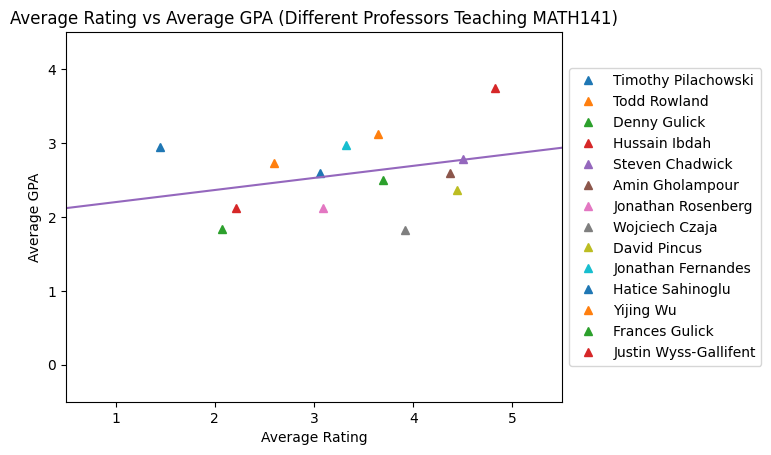

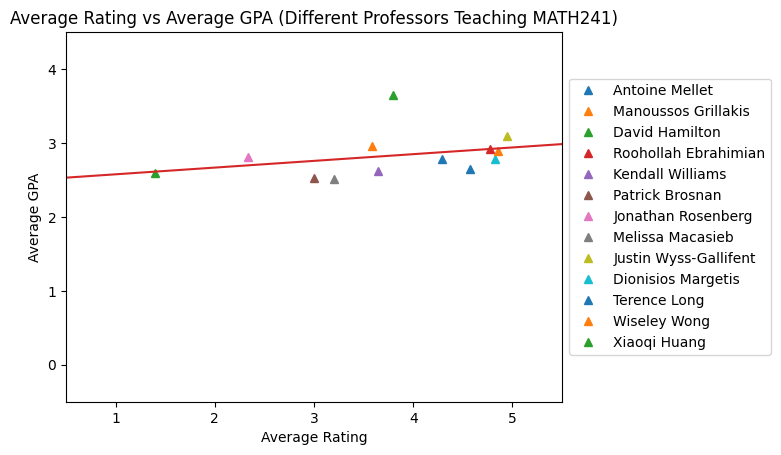

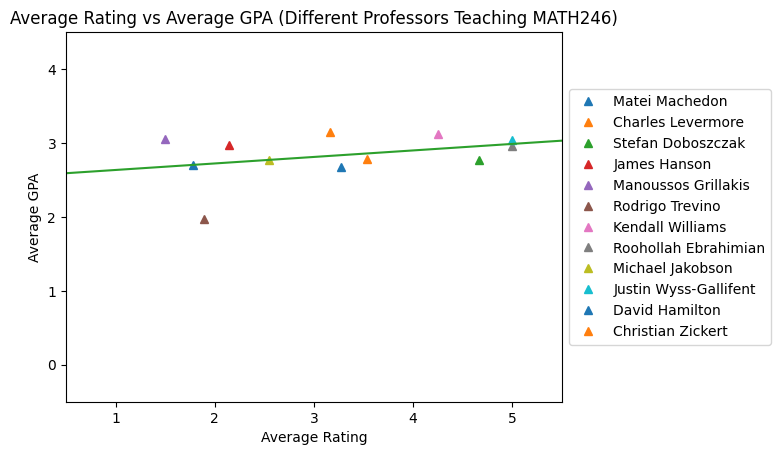

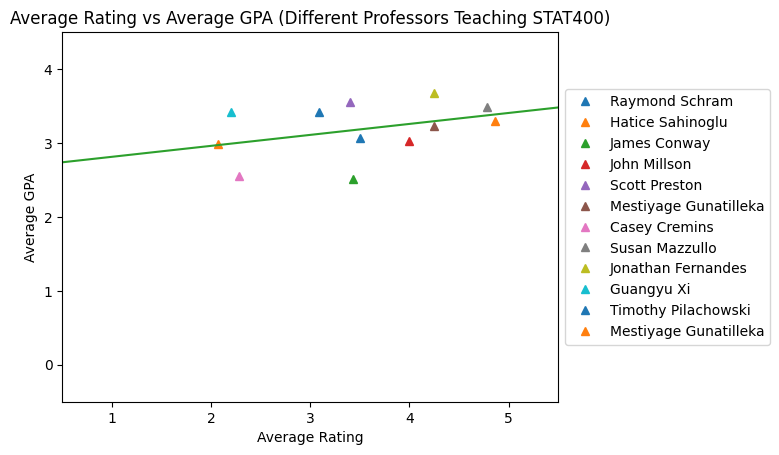

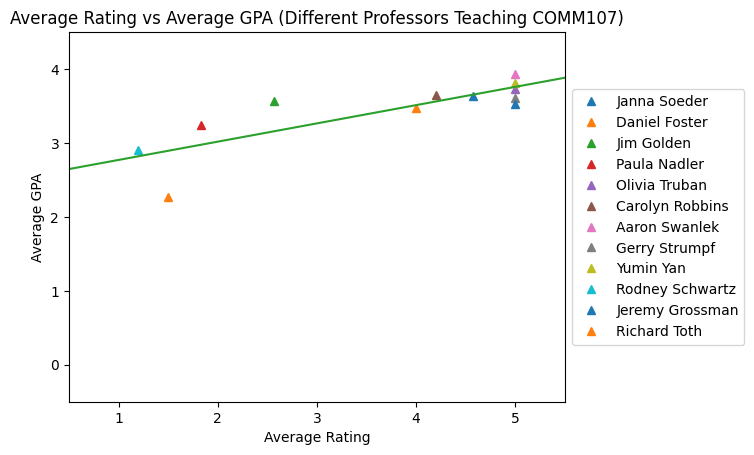

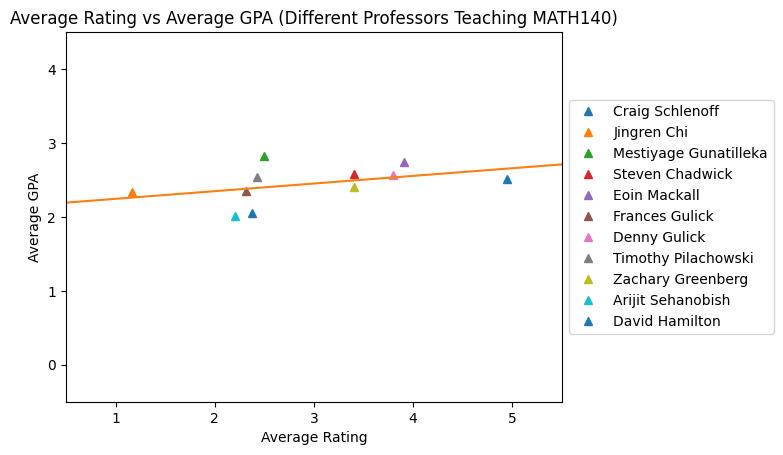

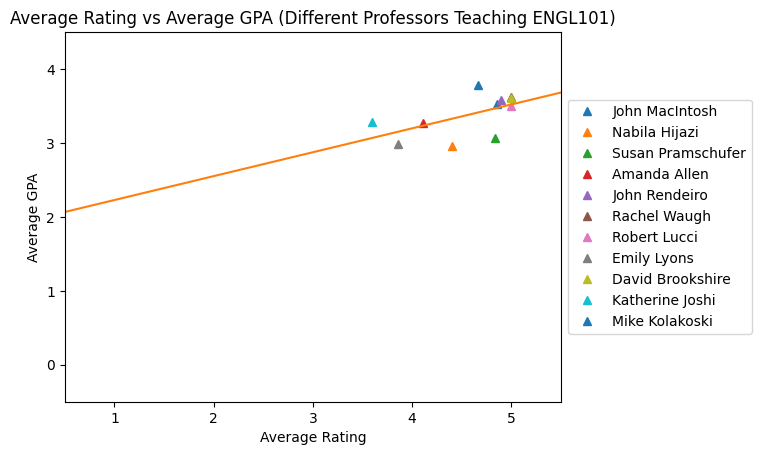

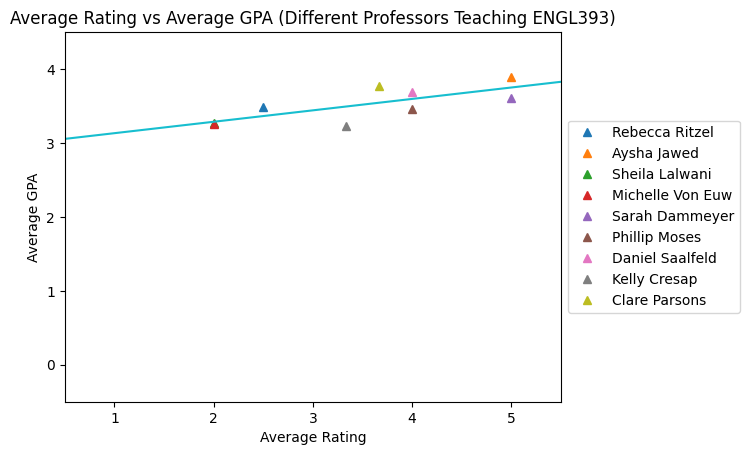

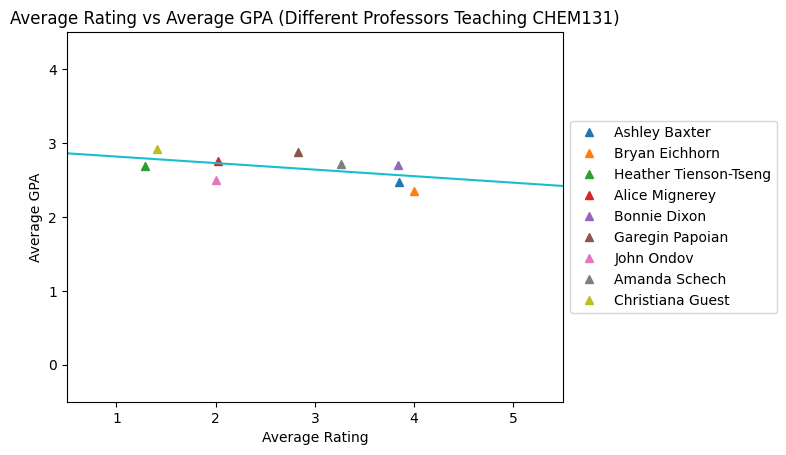

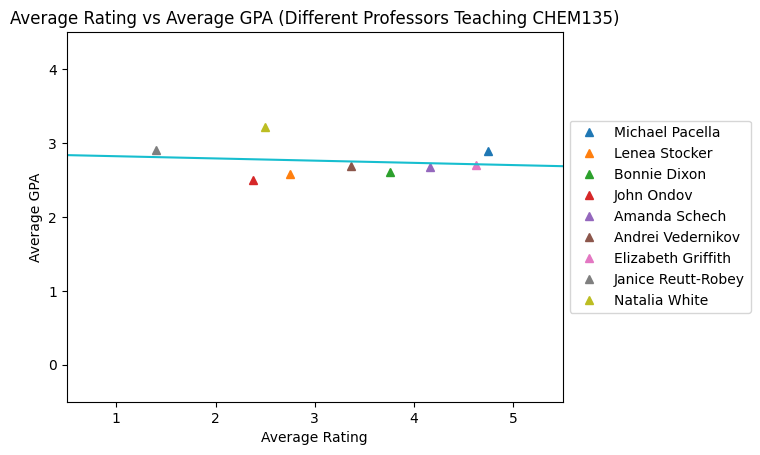

In [219]:
for i in most_profs_courses:
    profs = []
    ratings = []
    gpas = []

    # get all of the information for each professor that has taught the class
    for j in multi_course.get(i):
        profs.append(j[0])
        ratings.append(j[1])
        gpas.append(j[3])

    for j in range(len(profs)):
        plt.plot(ratings[j], gpas[j], "^", label = profs[j])

    plt.title("Average Rating vs Average GPA (Different Professors Teaching " + i + ")")
    plt.ylabel("Average GPA")
    plt.xlabel("Average Rating")
    plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
    
    # linear regression for gpa vs rating
    ratings = np.array(ratings).reshape(-1, 1)
    reg = linear_model.LinearRegression()
    regfit = reg.fit(ratings, gpas)
    X = np.linspace(-100, 100)
    y_pred = reg.predict(np.array(X).reshape(-1,1))
    plt.plot(X,y_pred)
    plt.xlim(0.5, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.show()

Again, there seems to generally be either a trend where higher ratings correlates to higher GPAs or little to no correlation at all. There is generally a higher range of ratings for each class, meaning that the regressions have more data to be trained on and are thus more reliable. Altogether, there is not sufficient evidence to say that there is any correlation between ratings and GPA in general, as a consistent trend has not been exhibited.

### Sentiment Analysis <a class="anchor" id = "sentiment-analysis"></a>

Since we have stored a database of all of the reviews, another thing we can analyze is how positive and negative each review is. To do this, we would use NLP and language processing to tokenize all of the words within a review, before eventually giving a score to summarize the general attitude of the review. Here, we plot the average rating for a class that a professor teaches with the average sentiment of all of the reviews for that class.

In [220]:
import nltk
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

reviews_df = reviews_df.dropna(subset = ['review'])

# get the sentiment for each review
for index, row in reviews_df.iterrows():
   reviews_df.at[index, "sentiment"] = sia.polarity_scores(reviews_df.at[index, "review"])["compound"]

average_sentiment_df = pd.DataFrame()
classes = {}
count = 0
curr_prof = reviews_df.at[0, "name"]
curr_slug = reviews_df.at[0, "slug"]
for index, row in reviews_df.iterrows():
    # get the average sentiment for each professor/class combination
    if reviews_df.at[index, "name"] == curr_prof:
        if reviews_df.at[index, "course"] in classes:
            classes[reviews_df.at[index, "course"]] = [classes.get(reviews_df.at[index, "course"])[0] + reviews_df.at[index, "rating"], 
                                                       classes.get(reviews_df.at[index, "course"])[1] + 1,
                                                       classes.get(reviews_df.at[index, "course"])[2] + reviews_df.at[index, "sentiment"]]
        else:
            classes[reviews_df.at[index, "course"]] = [reviews_df.at[index, "rating"],1,reviews_df.at[index, "sentiment"]]
    else:
        for i in classes.keys():
            # add to the dataframe
            average_sentiment_df.at[count, "name"] = curr_prof
            average_sentiment_df.at[count, "course"] = i
            average_sentiment_df.at[count, "slug"] = curr_slug
            average_sentiment_df.at[count, "average_rating"] = classes.get(i)[0]/classes.get(i)[1]
            average_sentiment_df.at[count, "num_ratings"] = classes.get(i)[1]
            average_sentiment_df.at[count, "average_sentiment"] = classes.get(i)[2]/classes.get(i)[1]
            count = count + 1
        classes = {}
        curr_prof = reviews_df.at[index, "name"]
        curr_slug = reviews_df.at[index, "slug"]

average_sentiment_df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/frenchfries11234/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,name,course,slug,average_rating,num_ratings,average_sentiment
0,A Anthony,AMST203,anthony,1.000000,1.0,-0.493900
1,A Sharma,ASTR300,sharma_a,2.000000,4.0,-0.494300
2,A.U. Shankar,CMSC216,shankar_a.u.,2.222222,18.0,0.208872
3,A.U. Shankar,CMSC412,shankar_a.u.,3.200000,5.0,0.139580
4,Aaron Bartlett,ENGL265,bartlett,2.000000,3.0,0.171600


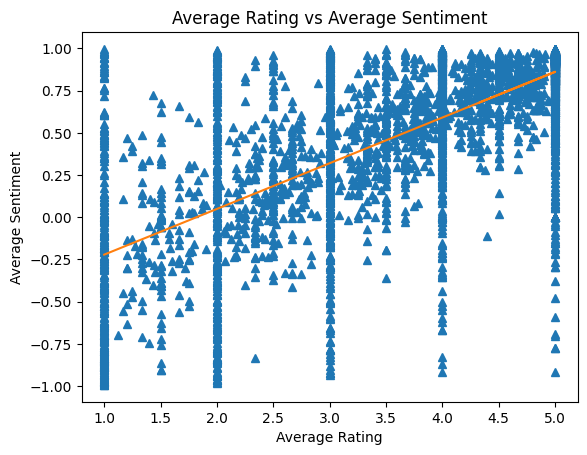

In [221]:
x = average_sentiment_df["average_rating"]
y = average_sentiment_df["average_sentiment"]

# Regression of average rating vs average sentiment
reg = linear_model.LinearRegression()
x_train = [[x] for x in average_sentiment_df["average_rating"].values]
y_train = [[y] for y in average_sentiment_df["average_sentiment"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Rating vs Average Sentiment")
plt.ylabel("Average Sentiment")
plt.xlabel("Average Rating")
plt.show()

As you might expect, there appears to be a positive trend between the average rating and the average sentiment. From here, we can see if there is any potential relationship between average salary and average sentiment, which is another way to measure public opinion of a professor.

In [222]:
# gets the average sentiment of a professor across all of their classes

def combine(group):
     return pd.Series({
        'average_rating': sum(group['average_rating'].tolist())/len(group['average_rating'].tolist()),
        'num_ratings': sum(group['num_ratings'].tolist())/len(group['num_ratings'].tolist()),
        'average_sentiment': sum(group['average_sentiment'].tolist())/len(group['average_sentiment'].tolist())
    })

average_prof_df = average_sentiment_df.groupby(['name']).apply(combine).reset_index()

average_prof_df["name"] = average_prof_df["name"].apply(lambda x: x.split()[0].upper()) + " " +average_prof_df["name"].apply(lambda x: x.split()[-1].upper())

average_prof_df.head()

,name,average_rating,num_ratings,average_sentiment
0,A ANTHONY,1.000000,1.0,-0.493900
1,A SHARMA,2.000000,4.0,-0.494300
2,A.U. SHANKAR,2.711111,11.5,0.174226
3,AARON BARTLETT,2.000000,3.0,0.171600
4,AARON FINKLE,2.500000,8.0,0.229350


In [223]:
# read our existing data, getting the average salary for a given professor

combined_data_df = pd.read_csv("src/2_clean_data/final_combine_data.csv")

combined_data_df = combined_data_df.drop(columns = ["course", "semester", "average_rating", "num_reviews", "average_gpa", 
                                                    "num_students", "years_taught", "departments", "real_name(s)", "_merge"])

# merge the average salary with the average sentiment
for index, row in combined_data_df.iterrows():
    temp = combined_data_df.at[index, "salaries"][1:-1].split(", ")
    nums = [eval(i) for i in temp]
    combined_data_df.at[index, "average_salary"] = sum(nums)/len(nums)

combined_data_df = combined_data_df.drop(columns = ["salaries"])

combined_data_df.head()

,name,average_salary
0,A SHARMA,86125.633000
1,AARON FINKLE,72452.691667
2,AARON HOOD,54602.026667
3,AARON SWANLEK,41046.400000
4,ABDIRISAK MOHAMED,17882.856667


In [224]:
# inner join on name
sal_sent_df = pd.merge(
    average_prof_df,
    combined_data_df,
    how = "inner",
    on = ["name"]
)

sal_sent_df.head()

,name,average_rating,num_ratings,average_sentiment,average_salary
0,A SHARMA,2.000000,4.0,-0.494300,86125.633000
1,A.U. SHANKAR,2.711111,11.5,0.174226,123066.228000
2,AARON FINKLE,2.500000,8.0,0.229350,72452.691667
3,AARON HOOD,5.000000,2.0,0.924000,54602.026667
4,AARON SWANLEK,5.000000,7.0,0.909614,41046.400000


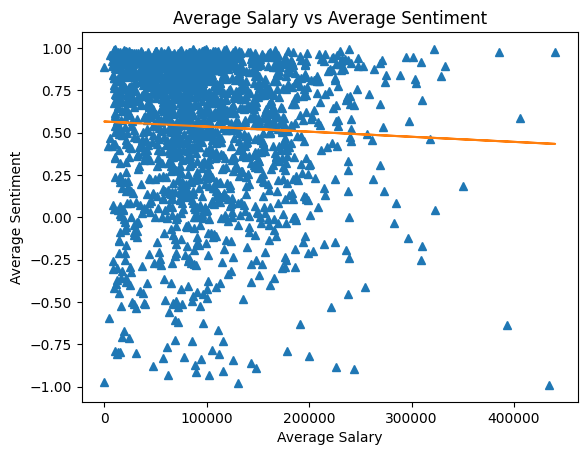

In [225]:
# plot salary vs sentiment

x = sal_sent_df["average_salary"]
y = sal_sent_df["average_sentiment"]

# Regression of average salary vs average sentiment
reg = linear_model.LinearRegression()
x_train = [[x] for x in sal_sent_df["average_salary"].values]
y_train = [[y] for y in sal_sent_df["average_sentiment"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Salary vs Average Sentiment")
plt.ylabel("Average Sentiment")
plt.xlabel("Average Salary")
plt.show()

Here, it appears that there is little to no correlation between the average salary of a professor and their average rating. This goes with the rest of the analysis that we have done, as there generally appears to be no correlation between the a professor's salary and the public opinion of them, since sentiment is another way of measuring public opinion.

# Conclusions, Interpretations, and Insights <a class="anchor" id = "conclusion"></a>

[Back to Top](#table)

The last step in the data science pipeline is the interpretation. All of the work that we did in the data science pipeline would be in vain if there is no one to read the work that we have done. Thus, it is important that we have a conclusion which wraps up our code nicely without having to read all of the project.

Throughout this tutorial, we have analyzed information about the professors at our University to try and find relationships between how much they get paid, how much experience they have, and how effective they are. The idea behind this is to try and help better inform all those involved, whether it be administrators trying to gauge how well students are responding to their faculty, or students trying to decide which professor to take for a given course. Either way, the data analysis performed thus far is important in discussing what potential relationships there are between these different factors.

From all of our data analysis, we have found no relationship between the independent variables (😔), how long a professor has been lecturing, and the salary of a professor, and the dependent variables, average grade of the class they taught, and the average rating of the class they taught. With intuition from our data visualization section, we assumed that the relationship between the variables would be hard to find, as it seems quite random and not related to each other. And even through our analysis with a linear regression, a logistic regression, a support vector machine, and a K-Nearest Neighbors algorithm, we found that they are not really linked together. 

With no luck finding a relationship between them, we wanted to look at the relationship between independent variables and the relationship between dependent variables, to see what really impacts each other. As such, we were able to conclude that there is a positive relationship between salary and the time a professor had taught. While this was not surprising to us, it gave us an understanding of how salary is impacted, and directly went against our hypothesis, that salary and time would impact grades and rating, when in reality there was no relationship with this implication.

Students view a professor’s value by their grades given in the class and the reviews given, but the university views a professor’s value by their experience and time spent at a university, which is reflected in the increase of salary over time. We wanted to see that the salary would be higher with better grades or better reviews, but we realized that it would incentivize a lot of grade inflation, as professors would just be handing out a lot more A’s, which would decrease the prestige of the university. But based on the frequency graph of average grades in the data visualization section, we see that the average grade per class is around 3.43, which translates to a B+, and that there is a left skew on the graph, with more students getting A’s, when we expected a more normal distribution around the B/C range. From this observation, we can conclude that the university’s expectation of prestige in terms of grades is around the B range, and that they may look at other metrics when it comes to the prestige of the university. 

Besides the relationship between time taught at a university and salary, there may have been other variables that we were not looking at that would impact how good a professor is. And so, there may be more analysis with other variables that we, or other researchers, could look at that may have a better relationship than what we explored.

Thus, as policy making, we would urge the university to continue paying professors the way they are doing, and possibly publicize and visualize more data regarding the performance of a professor, including but not limited to, a professor’s salary over time, grade distributions in a class, and the average ratings that a professor is getting in class, such that students may be appeased when they see lower grades, or give bad reviews for professors, and understand how they did based on distributions and how much a professor gets paid. 

The project has taught us that while the data science pipeline can be long and time-consuming, it is still a systematic and essential process that needs to be done to inform decisions in various fields. We hope that you have enjoyed following along through this project, and that you have learned something new about the data science pipeline and the professors at UMD. If you wish to look at our code in its entirety, please visit our github [here](https://github.com/achen132/achen132.github.io).